In [1]:
import wandb
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import dill
import numpy as np

In [2]:
test_nodes = ['15', '71', '0', '87', '19', '120', '85', '127', '32', '149', '38', '23', '126', '72', '7', '66', '2', '31', '128', '130', '89', '115', '131', '79', '36', '77', '81', '117', '140', '57', '53', '30', '139', '21', '138', '141', '142', '50', '78', '116', '12', '83', '56', '64', '24', '61', '92', '84', '34', '6'] 
counters_nodes = dill.load(open('./selected.pkl', 'rb'))
test_nodes_columns_disparity_dataset = [f"Test Node {name} - Disp. Dataset" for name in test_nodes]
test_nodes_columns_accuracy = [f"Test Node {name} - Acc." for name in test_nodes]
test_nodes_columns_disparity = [f"Test Node {name} - Disp." for name in test_nodes]
train_nodes = list(set([str(item) for item in range(0, 150)]) - set(test_nodes))
train_nodes_columns = [f"Lambda Client {node_name}" for node_name in train_nodes]
train_nodes_columns_disparity = [f"Disparity Client {node_name} After Local train" for node_name in train_nodes]
train_nodes_columns_disparity_before = [f"Disparity Client {node_name} Before local train" for node_name in train_nodes]

test_nodes_columns_test_accuracy = "Test Disparity"
test_nodes_columns_test_disparity = "Test Accuracy"

In [3]:
counters_nodes = dill.load(open('./not_selected.pkl', 'rb'))
node_disparities_fair = {}
node_disparities_unfair = {}

for node_name, node_info in counters_nodes.items():
    disparity = node_info[0]
    if disparity < 0.1:
        node_disparities_fair[node_name] = disparity
    else:
        node_disparities_unfair[node_name] = disparity

In [4]:
# train_nodes = dill.load(open('./not_selected.pkl', 'rb'))
# node_disparities_fair = {}
# node_disparities_unfair = {}

# for node_name, node_info in train_nodes.items():
#     disparity = node_info[0]
#     if disparity < 0.1:
#         node_disparities_fair[node_name] = disparity
#     else:
#         node_disparities_unfair[node_name] = disparity
# print(len(node_disparities_fair))
# print(len(node_disparities_unfair))

In [5]:
def get_df(api_link):
    api = wandb.Api()
    run = api.run(api_link)
    df = pd.DataFrame(run.scan_history())
    return df 

def remove_nan(column_names, dataframe):
    current_df = dataframe[column_names]
    # consider each column in training_data_disparity independently and 
    # remove the rows where we have NaN
    new_columns = [] 

    for column in current_df.columns:
        new_values = list(current_df[column].dropna())
        new_columns.append(new_values)

    # create the new dataframe with baseline_test_nodes_columns_disparity_dataset as columns
    # names and new_columns as values
    print(column_names)
    print(new_columns)
    new_df = pd.DataFrame(dict(zip(column_names, new_columns)))
    return new_df

In [6]:
def plot_disparity_dataset(df, node_names, file_name):
    nodes_with_disparity = {}
    for node_name, column in zip(node_names, df.columns):
        # get the last value of the column
        nodes_with_disparity[node_name] = df[column].iloc[-1]
    # dump nodes_with_disparity.values() in a file
    # dill.dump(nodes_with_disparity, open("nodes_with_disparity.pkl", "wb"))
    
    # plot an bar plot of the disparity values

    figure(figsize=(20, 8), dpi=80)
    # sort the nodes by disparity
    nodes_with_disparity = dict(sorted(nodes_with_disparity.items(), key=lambda item: item[1]))
    plt.bar(nodes_with_disparity.keys(), nodes_with_disparity.values())
    plt.xlabel("Nodes")
    plt.ylabel("Disparity")
    # font size 
    plt.rcParams.update({'font.size': 20})
    #rotate xticks
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title("Dataset disparity for each test node")
    plt.savefig(file_name)
    return nodes_with_disparity.keys()
    
def plot_different_distributions(counters_nodes, sorted_nodes, file_name):
    # we want to plot the different distributions of the nodes
    # in particular the amount of samples of group (0,1) and (1,1)
    one_zeros = []
    one_ones = []
    for node_name in sorted_nodes:
        one_zero = counters_nodes[node_name][1][(0,1)]
        one_one = counters_nodes[node_name][1][(1,1)]
        one_zeros.append(one_zero)
        one_ones.append(one_one)

    # plot a grouped bar chart with the values of one_zeros and one_ones
    # for each node. For each node I want to show two bars, one for one_zeros
    # and one for one_ones
    figure(figsize=(25, 8), dpi=80)
    plt.bar(sorted_nodes, one_zeros, width=0.4, align='edge')
    plt.bar(sorted_nodes, one_ones, width=-0.4, align='edge')
    plt.legend(["(0,1)", "(1,1)"])
    plt.xlabel("Nodes")
    plt.ylabel("Number of samples")
    # font size 
    plt.rcParams.update({'font.size': 17})
    #rotate xticks
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title("Distribution of samples (1,1) and (0,1) in the test nodes")
    plt.savefig(file_name)

def plot_fixed_vs_tunable(baseline, fixed, tunable, nodes, file_name, sorted_nodes, target):
    baseline_disparity_dict = {}
    fixed_disparity_dict = {}
    tunable_disparit_dict = {}
    for node_name, column in zip(nodes, baseline.columns):
        # get the last value of the column
        baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
        fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
        tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

    baseline_disparity = []
    fixed_disparity = []
    tunable_disparity = []
    for node in sorted_nodes:
        baseline_disparity.append(baseline_disparity_dict[node])
        fixed_disparity.append(fixed_disparity_dict[node])
        tunable_disparity.append(tunable_disparit_dict[node])
    
    width = 0.27 
    figure(figsize=(25, 8), dpi=80)
    indexes = np.arange(len(nodes))
    plt.bar(indexes, baseline_disparity, width=width)
    plt.bar(indexes+width, fixed_disparity, width=width)
    plt.bar(indexes+width*2, tunable_disparity, width=width)
    plt.axhline(y=target, color='purple', linestyle='--')
    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xticks(indexes + width, nodes)
    plt.rcParams.update({'font.size': 20})
    plt.xlabel("Nodes")
    plt.ylabel("Disparity")
    plt.xticks(rotation=90)
    plt.title("Comparison between the test disparity of the baseline, fixed and tunable Lambda")
    plt.savefig(file_name)

def plot_fixed_vs_tunable_line(baseline, fixed, tunable, nodes, file_name, sorted_nodes, target):
    # Plots the final disparity of the baseline, fixed and tunable models for each node
    baseline_disparity_dict = {}
    fixed_disparity_dict = {}
    tunable_disparit_dict = {}
    for node_name, column in zip(nodes, baseline.columns):
        # get the last value of the column
        baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
        fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
        tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

    baseline_disparity = []
    fixed_disparity = []
    tunable_disparity = []
    for node in sorted_nodes:
        baseline_disparity.append(baseline_disparity_dict[node])
        fixed_disparity.append(fixed_disparity_dict[node])
        tunable_disparity.append(tunable_disparit_dict[node])
    
    width = 0.27 
    figure(figsize=(25, 8), dpi=80)
    indexes = np.arange(len(nodes))
    
    plt.axhline(y=target, color='purple', linestyle='--')

    plt.scatter(indexes, baseline_disparity, marker='x', linewidths=4, s=100, color='red')
    plt.scatter(indexes, fixed_disparity, marker='o', linewidths=4, s=100, color='green')
    plt.scatter(indexes, tunable_disparity, marker='+', linewidths=4, s=100, color='blue')

    plt.plot(indexes, baseline_disparity, linewidth=1, color='red')
    plt.plot(indexes, fixed_disparity, linewidth=1, color='green')
    plt.plot(indexes, tunable_disparity, linewidth=1, color='blue')
    # ax = plt.axes()        
    # ax.yaxis.grid()

    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xticks(indexes + width, nodes)
    plt.rcParams.update({'font.size': 20})
    plt.xlabel("Nodes")
    plt.ylabel("Disparity")
    plt.xticks(rotation=90)
    plt.title("Comparison between the test disparity of the baseline, fixed and tunable Lambda")
    plt.savefig(file_name)

def plot_difference_disparity(baseline, fixed, tunable, nodes, file_name, sorted_nodes, target):
    # plot the difference between the disparity of the baseline and the disparity of the fixed
    # and tunable models. This is a grouped bar chart with 2 bars for each node, one for the fixed
    # and one for the tunable.
    baseline_disparity_dict = {}
    fixed_disparity_dict = {}
    tunable_disparit_dict = {}
    for node_name, column in zip(nodes, baseline.columns):
        # get the last value of the column
        baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
        fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
        tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

    fixed_disparity = []
    tunable_disparity = []
    for node in sorted_nodes:
        fixed_disparity.append(baseline_disparity_dict[node]-fixed_disparity_dict[node])
        tunable_disparity.append(baseline_disparity_dict[node]-tunable_disparit_dict[node])
    
    width = 0.27 
    figure(figsize=(25, 8), dpi=80)
    indexes = np.arange(len(nodes))
    plt.bar(indexes, fixed_disparity, width=width)
    plt.bar(indexes+width, tunable_disparity, width=width)
    plt.legend(["Fixed", "Tunable"])
    plt.xticks(indexes + width, nodes)
    plt.rcParams.update({'font.size': 20})
    plt.xlabel("Nodes")
    plt.ylabel("Difference")
    plt.xticks(rotation=90)
    plt.title("Difference between the test disparity of the baseline and the disparity of the fixed and tunable Lambda")
    plt.savefig(file_name)

def plot_difference_disparity_line(baseline, fixed, tunable, nodes, file_name, sorted_nodes, target):
    # plot the difference between the disparity of the baseline and the disparity of the fixed
    # and tunable models. This is a grouped bar chart with 2 bars for each node, one for the fixed
    # and one for the tunable.
    baseline_disparity_dict = {}
    fixed_disparity_dict = {}
    tunable_disparit_dict = {}
    for node_name, column in zip(nodes, baseline.columns):
        # get the last value of the column
        baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
        fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
        tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

    fixed_disparity = []
    tunable_disparity = []
    for node in sorted_nodes:
        fixed_disparity.append(baseline_disparity_dict[node]-fixed_disparity_dict[node])
        tunable_disparity.append(baseline_disparity_dict[node]-tunable_disparit_dict[node])
    
    width = 0.27 
    figure(figsize=(25, 8), dpi=80)
    indexes = np.arange(len(nodes))
    

    plt.scatter(indexes, fixed_disparity, marker='o', linewidths=4, s=100, color='green')
    plt.scatter(indexes, tunable_disparity, marker='+', linewidths=4, s=100, color='blue')
    # ax = plt.axes()        
    # ax.yaxis.grid()

    plt.plot(indexes, fixed_disparity, linewidth=1, color='green')
    plt.plot(indexes, tunable_disparity, linewidth=1, color='blue')
    plt.legend(["Fixed", "Tunable"])
    plt.xticks(indexes + width, nodes)
    plt.rcParams.update({'font.size': 20})
    plt.xlabel("Nodes")
    plt.ylabel("Difference")
    plt.xticks(rotation=90)
    plt.title("Difference between the test disparity of the baseline and the disparity of the fixed and tunable Lambda")
    plt.savefig(file_name)

In [7]:
def plot_fixed_vs_tunable_accuracy(baseline, fixed, tunable, nodes, file_name, sorted_nodes, target):
    # Plots the final accuracy of the baseline, fixed and tunable models for each node
    baseline_disparity_dict = {}
    fixed_disparity_dict = {}
    tunable_disparit_dict = {}
    for node_name, column in zip(nodes, baseline.columns):
        # get the last value of the column
        baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
        fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
        tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

    baseline_disparity = []
    fixed_disparity = []
    tunable_disparity = []
    for node in sorted_nodes:
        baseline_disparity.append(baseline_disparity_dict[node])
        fixed_disparity.append(fixed_disparity_dict[node])
        tunable_disparity.append(tunable_disparit_dict[node])
    
    width = 0.27 
    figure(figsize=(25, 8), dpi=80)
    indexes = np.arange(len(nodes))
    plt.bar(indexes, baseline_disparity, width=width)
    plt.bar(indexes+width, fixed_disparity, width=width)
    plt.bar(indexes+width*2, tunable_disparity, width=width)
    # plt.axhline(y=target, color='purple', linestyle='--')
    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xticks(indexes + width, nodes)
    plt.rcParams.update({'font.size': 20})
    plt.xlabel("Nodes")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.title("Comparison between the test accuracy of the baseline, fixed and tunable Lambda")
    plt.savefig(file_name)

def plot_fixed_vs_tunable_accuracy_line(baseline, fixed, tunable, nodes, file_name, sorted_nodes, target):
    # Plots the final accuracy of the baseline, fixed and tunable models for each node
    baseline_disparity_dict = {}
    fixed_disparity_dict = {}
    tunable_disparit_dict = {}
    for node_name, column in zip(nodes, baseline.columns):
        # get the last value of the column
        baseline_disparity_dict[node_name] = baseline[column].iloc[-1]
        fixed_disparity_dict[node_name] = fixed[column].iloc[-1]
        tunable_disparit_dict[node_name] = tunable[column].iloc[-1]

    baseline_disparity = []
    fixed_disparity = []
    tunable_disparity = []
    for node in sorted_nodes:
        baseline_disparity.append(baseline_disparity_dict[node])
        fixed_disparity.append(fixed_disparity_dict[node])
        tunable_disparity.append(tunable_disparit_dict[node])
    
    width = 0.27 
    figure(figsize=(25, 8), dpi=80)
    indexes = np.arange(len(nodes))
    
    # plt.axhline(y=target, color='purple', linestyle='--')

    plt.scatter(indexes, baseline_disparity, marker='x', linewidths=3, s=100, color='red')
    plt.scatter(indexes, fixed_disparity, marker='o', linewidths=3, s=100, color='green')
    plt.scatter(indexes, tunable_disparity, marker='+', linewidths=3, s=100, color='blue')

    plt.plot(indexes, baseline_disparity, linewidth=1, color='red')
    plt.plot(indexes, fixed_disparity, linewidth=1, color='green')
    plt.plot(indexes, tunable_disparity, linewidth=1, color='blue')
    # ax = plt.axes()        
    # ax.yaxis.grid()

    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xticks(indexes + width, nodes)
    plt.rcParams.update({'font.size': 20})
    plt.xlabel("Nodes")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.title("Comparison between the test accuracy of the baseline, fixed and tunable Lambda")
    plt.savefig(file_name)

In [8]:
def plot_lambda(baseline, fixed, tunable, nodes, file_name, target):
    accuracy_baseline = list(baseline["Aggregated Lambda"].dropna())
    accuracy_fixed = list(fixed["Aggregated Lambda"].dropna())
    accuracy_tunable = list(tunable["Aggregated Lambda"].dropna())

    print(accuracy_baseline)
    # plot the three lines
    figure(figsize=(25, 8), dpi=80)
    # grid 
    ax = plt.axes()        
    ax.yaxis.grid()
    plt.plot(accuracy_baseline, linewidth=2, color='red')
    plt.plot(accuracy_fixed, linewidth=2, color='green')
    plt.plot(accuracy_tunable, linewidth=2, color='blue')
    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xlabel("FL Rounds")
    plt.ylabel("Lambda")
    plt.title(f"Comparison of the Lambda in the Baseline, Fixed and Tunable models")
    plt.savefig(file_name)

def plot_accuracy_comparison(baseline, fixed, tunable, nodes, file_name, target):
    accuracy_baseline = list(baseline["Test Accuracy"].dropna())
    accuracy_fixed = list(fixed["Test Accuracy"].dropna())
    accuracy_tunable = list(tunable["Test Accuracy"].dropna())

    print(accuracy_baseline)
    # plot the three lines
    figure(figsize=(25, 8), dpi=80)
    # grid 
    ax = plt.axes()        
    ax.yaxis.grid()
    plt.plot(accuracy_baseline, linewidth=2, color='red')
    plt.plot(accuracy_fixed, linewidth=2, color='green')
    plt.plot(accuracy_tunable, linewidth=2, color='blue')
    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xlabel("FL Rounds")
    plt.ylabel("Accuracy")
    plt.title(f"Test Accuracy comparison between the baseline, fixed and tunable Lambda")
    plt.savefig(file_name)

def plot_disparity_comparison(baseline, fixed, tunable, nodes, file_name, target):
    disparity_baseline = list(baseline["Test Disparity with statistics"].dropna())
    disparity_fixed = list(fixed["Test Disparity with statistics"].dropna())
    disparity_tunable = list(tunable["Test Disparity with statistics"].dropna())

    # plot the three lines
    figure(figsize=(25, 8), dpi=80)
    ax = plt.axes()        
    ax.yaxis.grid()
    plt.plot(disparity_baseline, linewidth=2, color='red')
    plt.plot(disparity_fixed, linewidth=2, color='green')
    plt.plot(disparity_tunable, linewidth=2, color='blue')
    # plot horizontal line at target 
    plt.axhline(y=target, color='purple', linestyle='--')
    
    plt.legend(["Baseline", "Fixed", "Tunable"])
    plt.xlabel("FL Rounds")
    plt.ylabel("Disparity")
    plt.title(f"Test Disparity comparison between the baseline, fixed and tunable Lambda")
    plt.savefig(file_name)
    

In [9]:
def process_and_plot(baseline_link, fixed_link, tunable_link, experiment, target):
    df_baseline = get_df(baseline_link)
    df_fixed = get_df(fixed_link)
    df_tunable = get_df(tunable_link)
    
    baseline_test_nodes_columns_disparity_dataset = remove_nan(test_nodes_columns_disparity_dataset, df_baseline)
    baseline_test_nodes_columns_accuracy = remove_nan(test_nodes_columns_accuracy, df_baseline)
    baseline_test_nodes_columns_disparity = remove_nan(test_nodes_columns_disparity, df_baseline)

    fixed_test_nodes_columns_disparity_dataset = remove_nan(test_nodes_columns_disparity_dataset, df_fixed)
    fixed_test_nodes_columns_accuracy = remove_nan(test_nodes_columns_accuracy, df_fixed)
    fixed_test_nodes_columns_disparity = remove_nan(test_nodes_columns_disparity, df_fixed)

    tunable_test_nodes_columns_disparity_dataset = remove_nan(test_nodes_columns_disparity_dataset, df_tunable)
    tunable_test_nodes_columns_accuracy = remove_nan(test_nodes_columns_accuracy, df_tunable)
    tunable_test_nodes_columns_disparity = remove_nan(test_nodes_columns_disparity, df_tunable)


    sorted_nodes = plot_disparity_dataset(baseline_test_nodes_columns_disparity_dataset, test_nodes, file_name=f"disparity_dataset_{experiment}.png")

    plot_different_distributions(counters_nodes, sorted_nodes, file_name=f"distribution_{experiment}.png")

    plot_accuracy_comparison(baseline=df_baseline, fixed=df_fixed, tunable=df_tunable, nodes=test_nodes, file_name=f"accuracy_{experiment}.png", target=target)
    plot_disparity_comparison(baseline=df_baseline, fixed=df_fixed, tunable=df_tunable, nodes=test_nodes, file_name=f"disparity_{experiment}.png",  target=target)
    plot_lambda(baseline=df_baseline, fixed=df_fixed, tunable=df_tunable, nodes=test_nodes, file_name=f"lambda_{experiment}.png",  target=target)

    plot_fixed_vs_tunable(baseline=baseline_test_nodes_columns_disparity, fixed=fixed_test_nodes_columns_disparity, tunable=tunable_test_nodes_columns_disparity, nodes=test_nodes, file_name=f"comparison_disparities_{experiment}.png", sorted_nodes=sorted_nodes, target=target)
    plot_fixed_vs_tunable_line(baseline=baseline_test_nodes_columns_disparity, fixed=fixed_test_nodes_columns_disparity, tunable=tunable_test_nodes_columns_disparity, nodes=test_nodes, file_name=f"comparison_disparities_with_line{experiment}.png", sorted_nodes=sorted_nodes, target=target)

    plot_fixed_vs_tunable_accuracy(baseline=baseline_test_nodes_columns_accuracy, fixed=fixed_test_nodes_columns_accuracy, tunable=tunable_test_nodes_columns_accuracy, nodes=test_nodes, file_name=f"comparison_accuracy_{experiment}.png", sorted_nodes=sorted_nodes, target=target)
    plot_fixed_vs_tunable_accuracy_line(baseline=baseline_test_nodes_columns_accuracy, fixed=fixed_test_nodes_columns_accuracy, tunable=tunable_test_nodes_columns_accuracy, nodes=test_nodes, file_name=f"comparison_accuracy_with_line_{experiment}.png", sorted_nodes=sorted_nodes, target=target)

    plot_difference_disparity(baseline=baseline_test_nodes_columns_disparity, fixed=fixed_test_nodes_columns_disparity, tunable=tunable_test_nodes_columns_disparity, nodes=test_nodes, file_name=f"difference_disparity_{experiment}.png", sorted_nodes=sorted_nodes, target=target)
    plot_difference_disparity_line(baseline=baseline_test_nodes_columns_disparity, fixed=fixed_test_nodes_columns_disparity, tunable=tunable_test_nodes_columns_disparity, nodes=test_nodes, file_name=f"difference_disparity__with_line_{experiment}.png", sorted_nodes=sorted_nodes, target=target)

    

In [10]:
baseline_link="/lucacorbucci/FL_fairness/runs/ydjnxo29"
df_baseline = get_df(baseline_link)
baseline_test_nodes_columns_disparity_dataset = remove_nan(test_nodes_columns_disparity_dataset, df_baseline)

nodes_with_disparity = {}
for node_name, column in zip(test_nodes, baseline_test_nodes_columns_disparity_dataset.columns):
    # get the last value of the column
    nodes_with_disparity[node_name] = baseline_test_nodes_columns_disparity_dataset[column].iloc[-1]
# dump nodes_with_disparity.values() in a file
dill.dump(nodes_with_disparity, open("nodes_with_disparity_test.pkl", "wb"))


['Test Node 15 - Disp. Dataset', 'Test Node 71 - Disp. Dataset', 'Test Node 0 - Disp. Dataset', 'Test Node 87 - Disp. Dataset', 'Test Node 19 - Disp. Dataset', 'Test Node 120 - Disp. Dataset', 'Test Node 85 - Disp. Dataset', 'Test Node 127 - Disp. Dataset', 'Test Node 32 - Disp. Dataset', 'Test Node 149 - Disp. Dataset', 'Test Node 38 - Disp. Dataset', 'Test Node 23 - Disp. Dataset', 'Test Node 126 - Disp. Dataset', 'Test Node 72 - Disp. Dataset', 'Test Node 7 - Disp. Dataset', 'Test Node 66 - Disp. Dataset', 'Test Node 2 - Disp. Dataset', 'Test Node 31 - Disp. Dataset', 'Test Node 128 - Disp. Dataset', 'Test Node 130 - Disp. Dataset', 'Test Node 89 - Disp. Dataset', 'Test Node 115 - Disp. Dataset', 'Test Node 131 - Disp. Dataset', 'Test Node 79 - Disp. Dataset', 'Test Node 36 - Disp. Dataset', 'Test Node 77 - Disp. Dataset', 'Test Node 81 - Disp. Dataset', 'Test Node 117 - Disp. Dataset', 'Test Node 140 - Disp. Dataset', 'Test Node 57 - Disp. Dataset', 'Test Node 53 - Disp. Dataset', 

In [11]:
# baseline_link="/lucacorbucci/FL_fairness/runs/ydjnxo29"
# df_baseline = get_df(baseline_link)
# baseline_test_nodes_columns_disparity_dataset = remove_nan(test_nodes_columns_disparity_dataset, df_baseline)

# nodes_with_disparity = {}
# for node_name, column in zip(test_nodes, baseline_test_nodes_columns_disparity_dataset.columns):
#     # get the last value of the column
#     nodes_with_disparity[node_name] = baseline_test_nodes_columns_disparity_dataset[column].iloc[-1]
# # dump nodes_with_disparity.values() in a file
# dill.dump(nodes_with_disparity, open("nodes_with_disparity_train.pkl", "wb"))

['Test Node 15 - Disp. Dataset', 'Test Node 71 - Disp. Dataset', 'Test Node 0 - Disp. Dataset', 'Test Node 87 - Disp. Dataset', 'Test Node 19 - Disp. Dataset', 'Test Node 120 - Disp. Dataset', 'Test Node 85 - Disp. Dataset', 'Test Node 127 - Disp. Dataset', 'Test Node 32 - Disp. Dataset', 'Test Node 149 - Disp. Dataset', 'Test Node 38 - Disp. Dataset', 'Test Node 23 - Disp. Dataset', 'Test Node 126 - Disp. Dataset', 'Test Node 72 - Disp. Dataset', 'Test Node 7 - Disp. Dataset', 'Test Node 66 - Disp. Dataset', 'Test Node 2 - Disp. Dataset', 'Test Node 31 - Disp. Dataset', 'Test Node 128 - Disp. Dataset', 'Test Node 130 - Disp. Dataset', 'Test Node 89 - Disp. Dataset', 'Test Node 115 - Disp. Dataset', 'Test Node 131 - Disp. Dataset', 'Test Node 79 - Disp. Dataset', 'Test Node 36 - Disp. Dataset', 'Test Node 77 - Disp. Dataset', 'Test Node 81 - Disp. Dataset', 'Test Node 117 - Disp. Dataset', 'Test Node 140 - Disp. Dataset', 'Test Node 57 - Disp. Dataset', 'Test Node 53 - Disp. Dataset', 

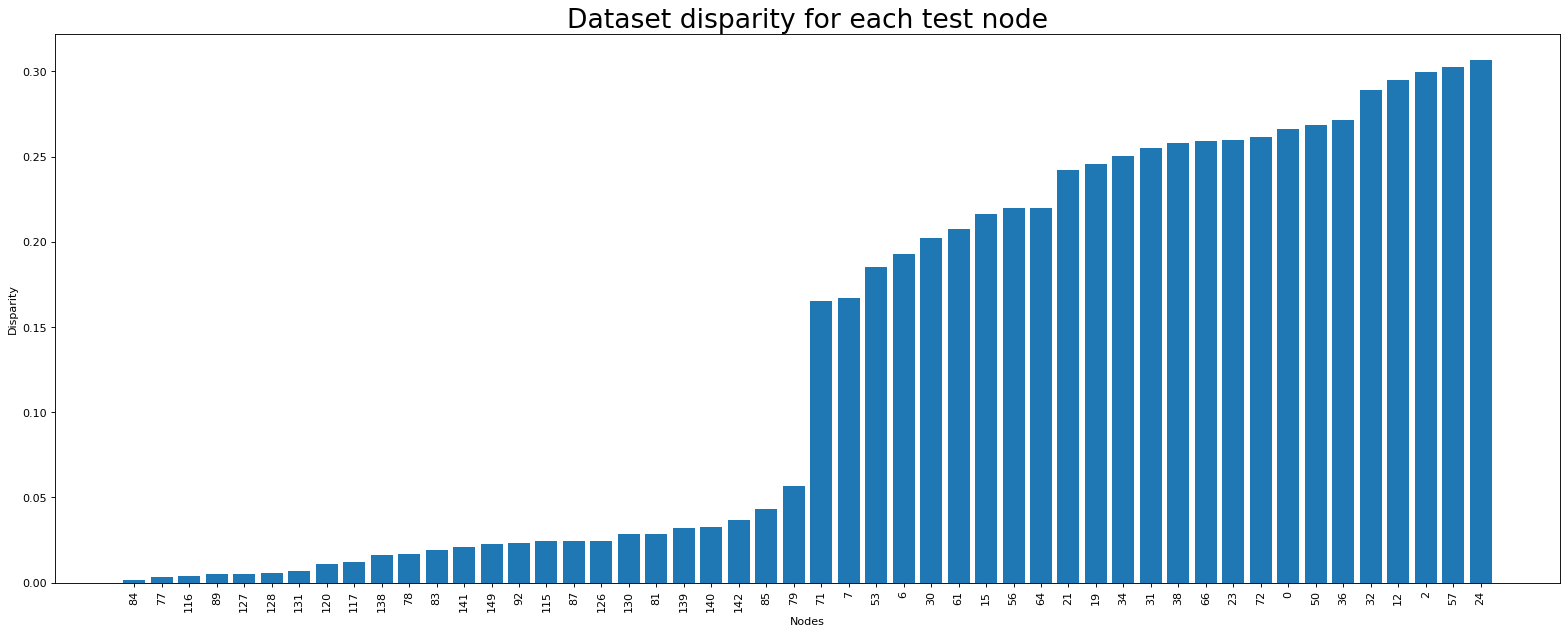

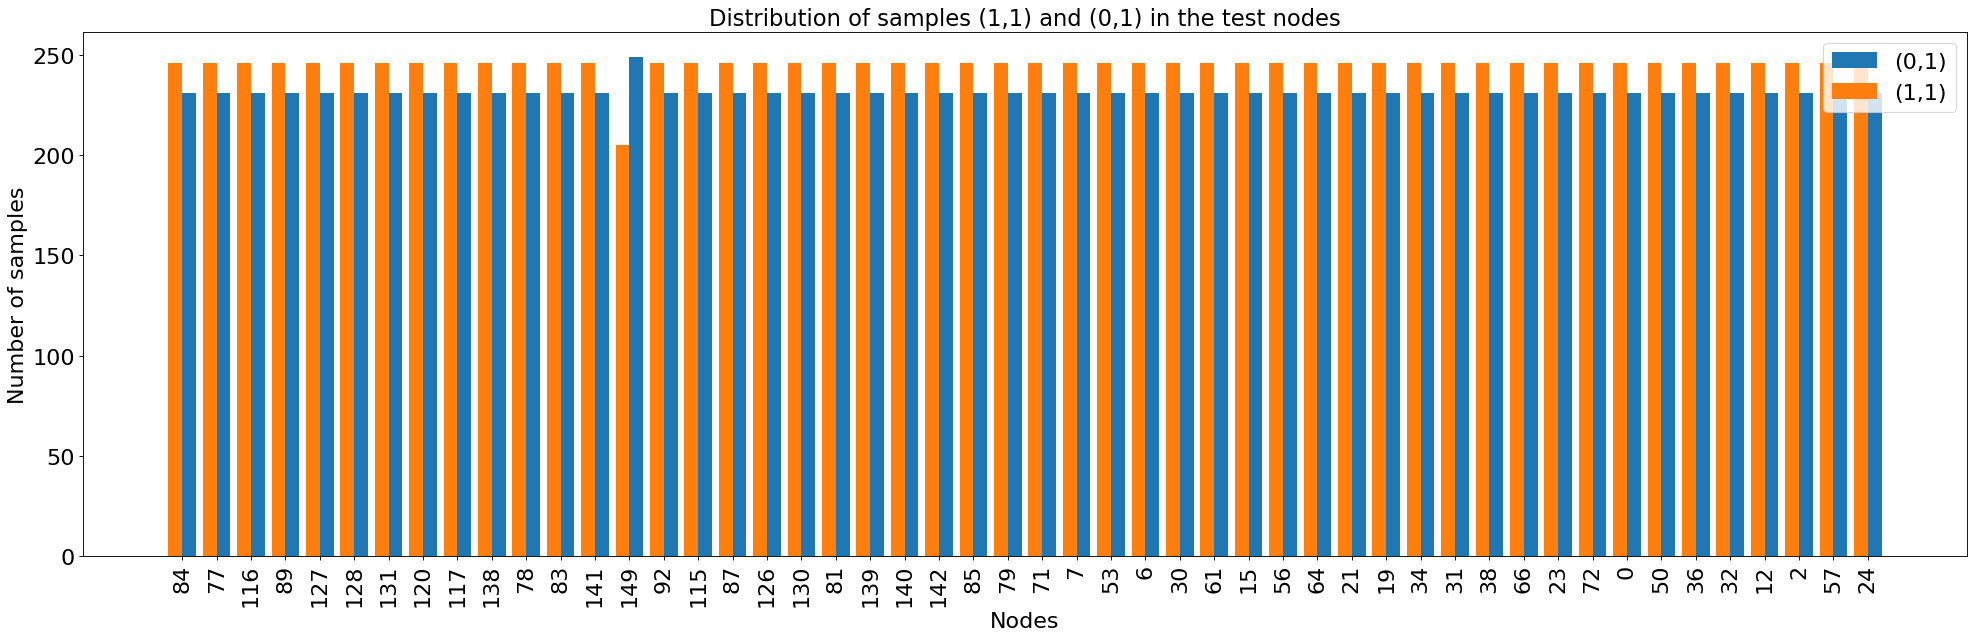

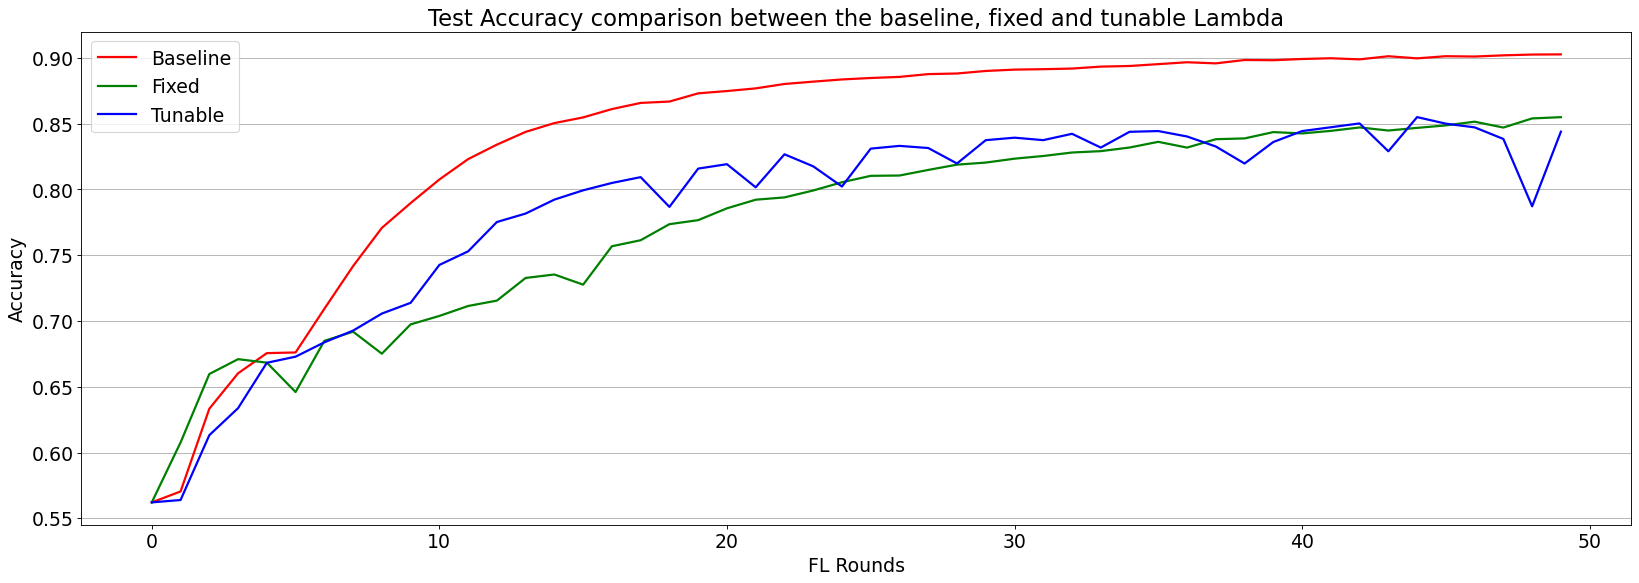

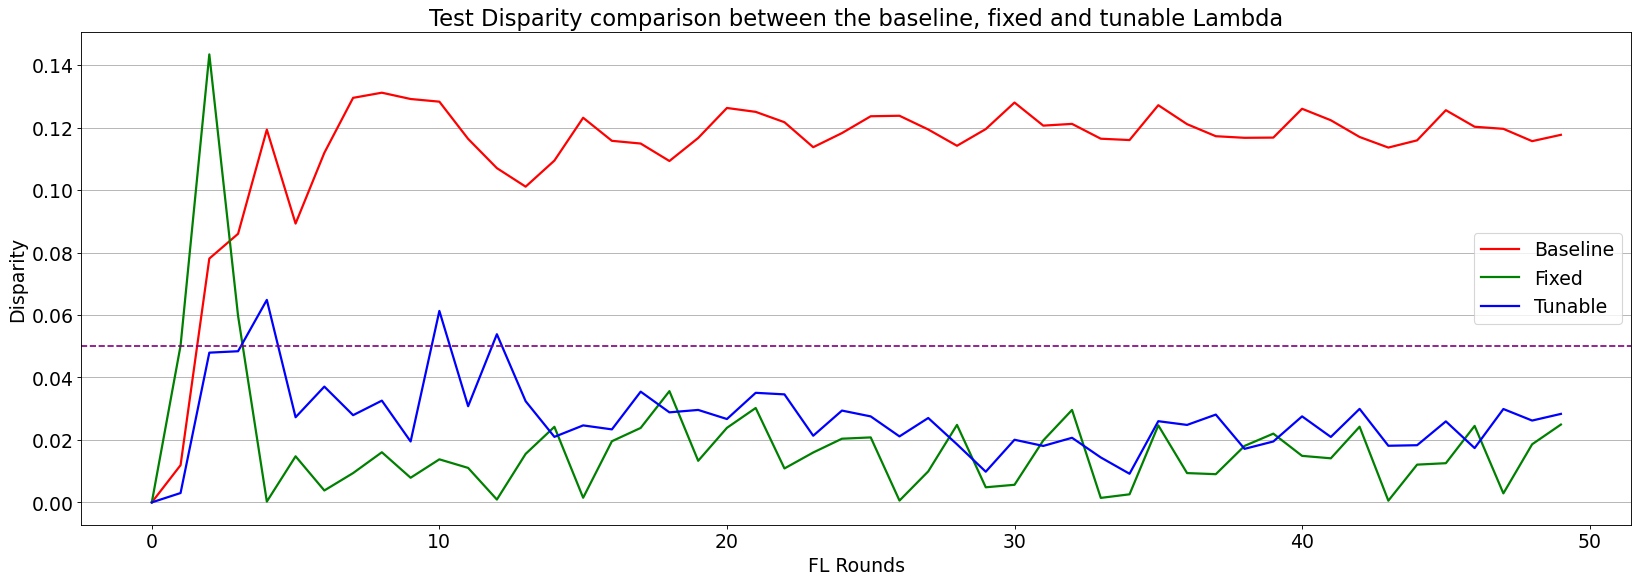

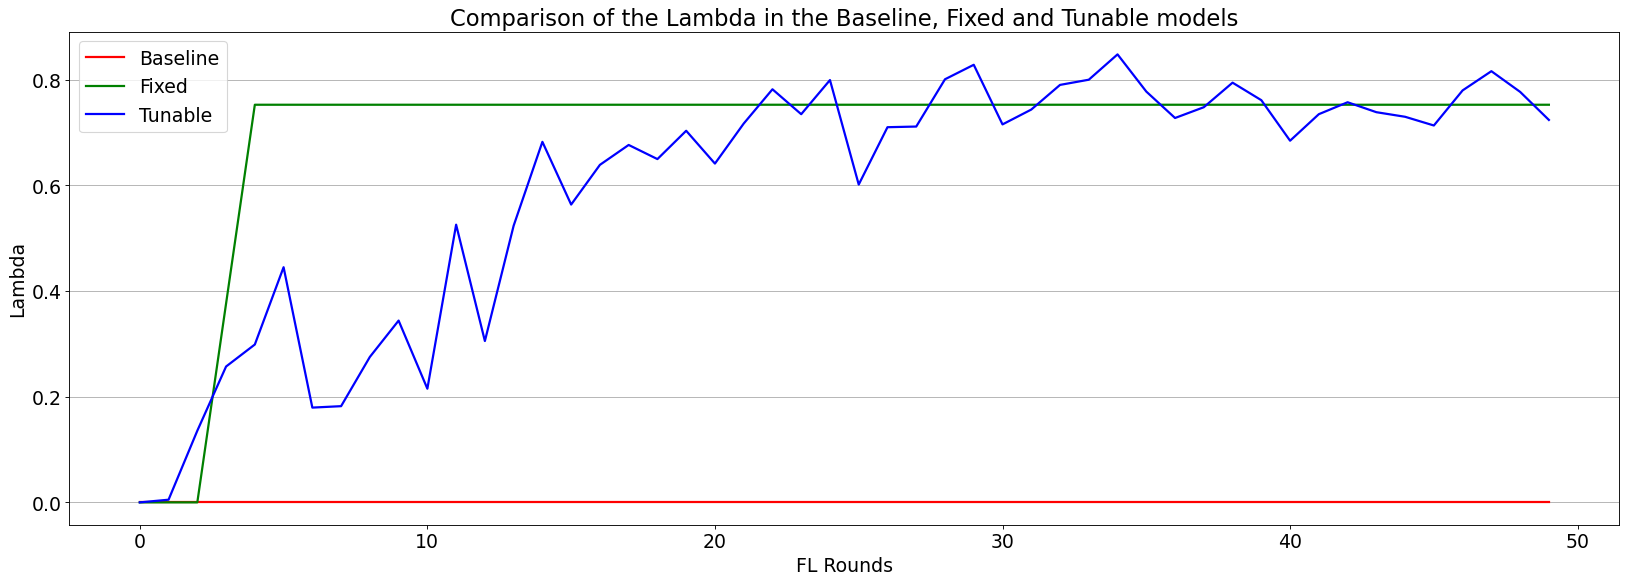

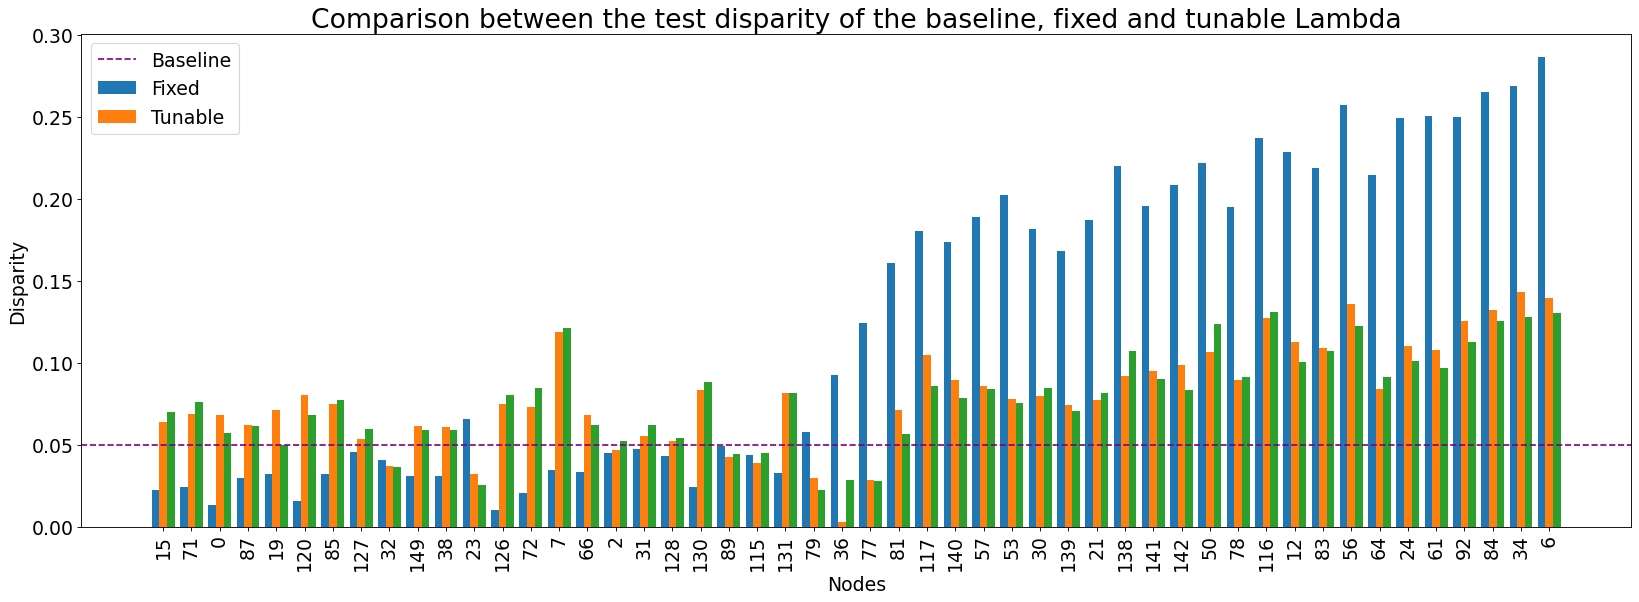

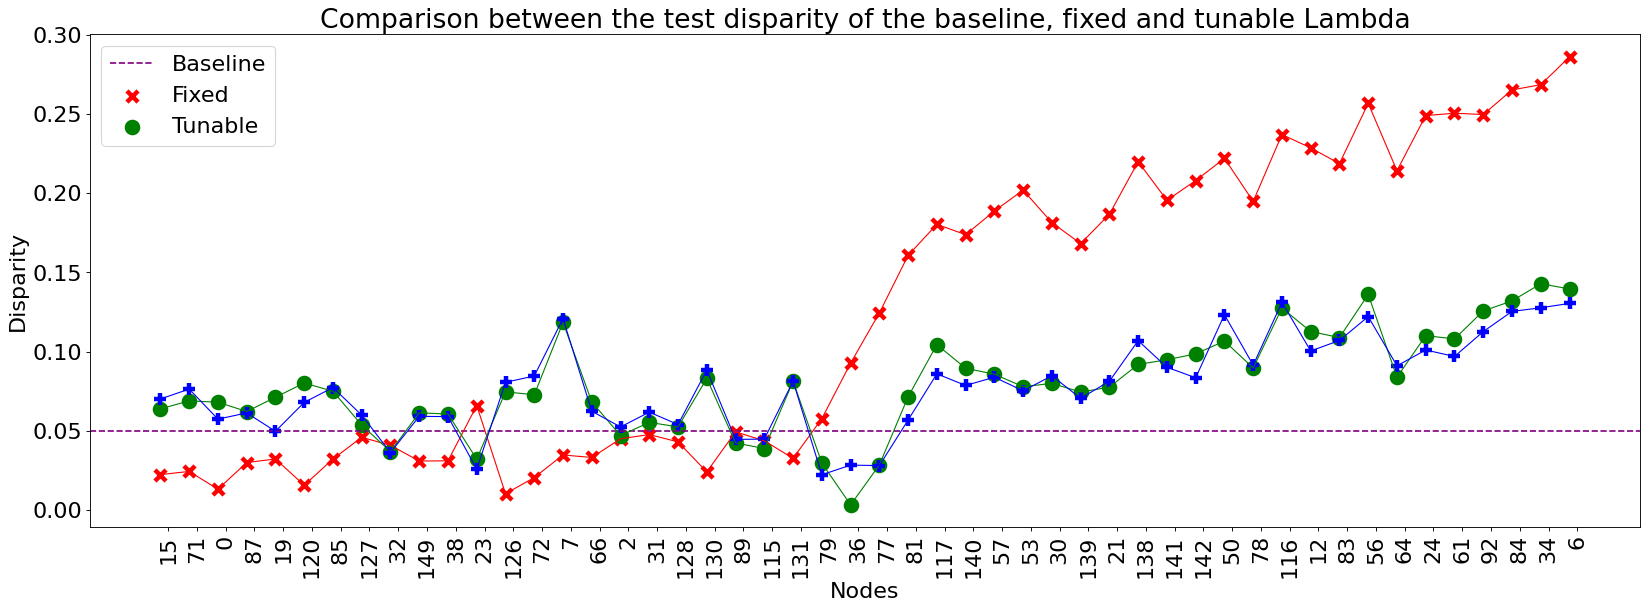

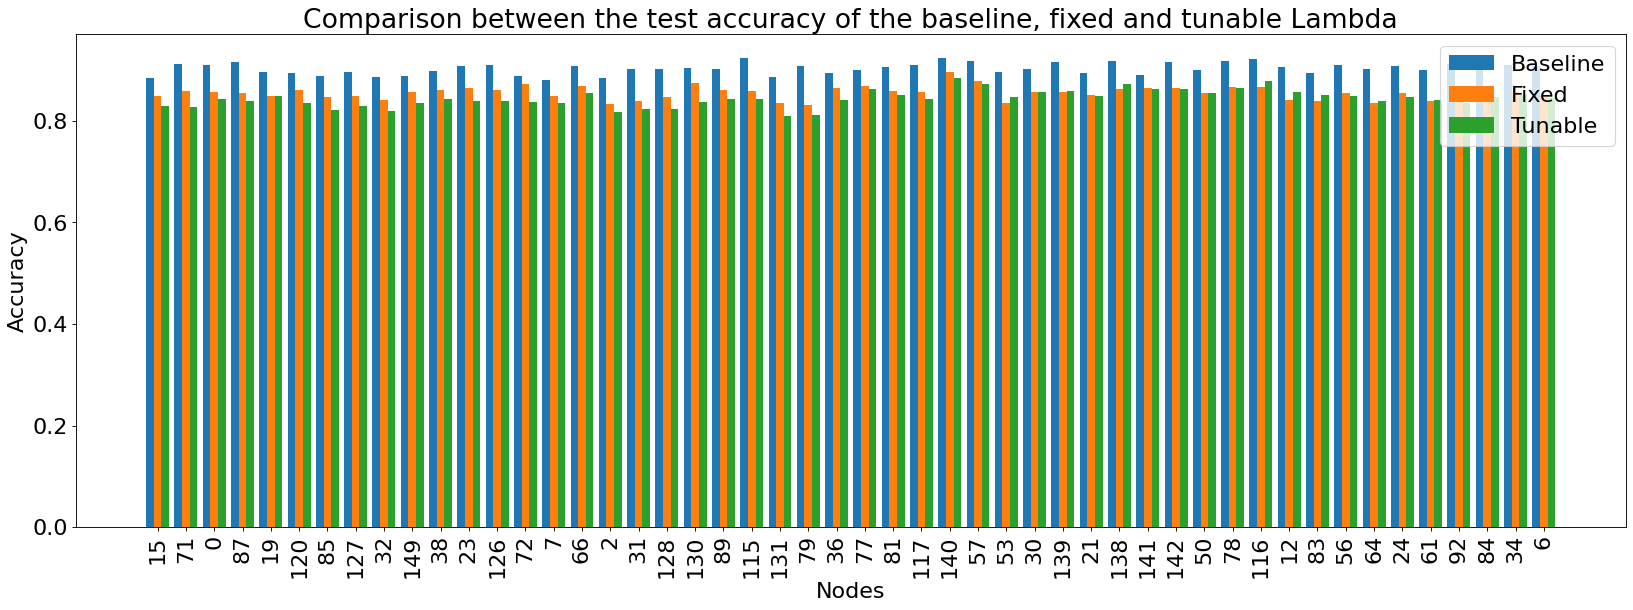

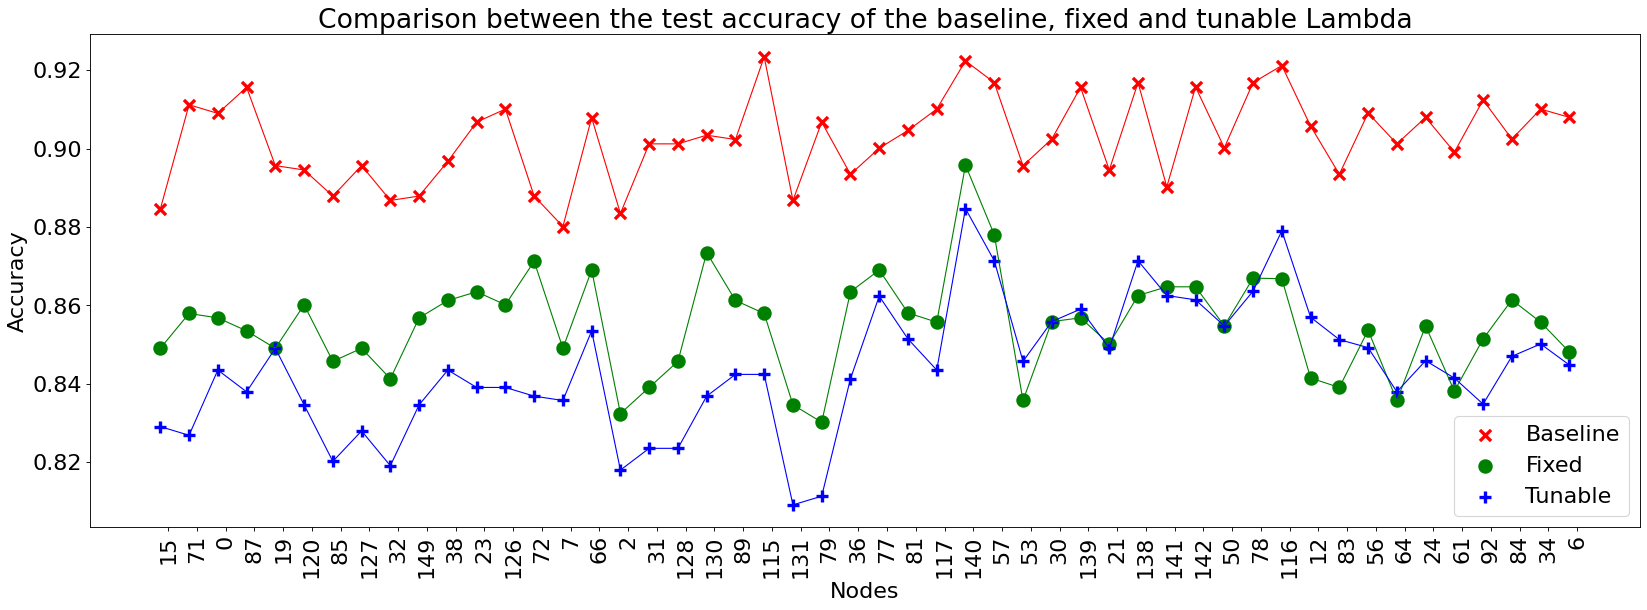

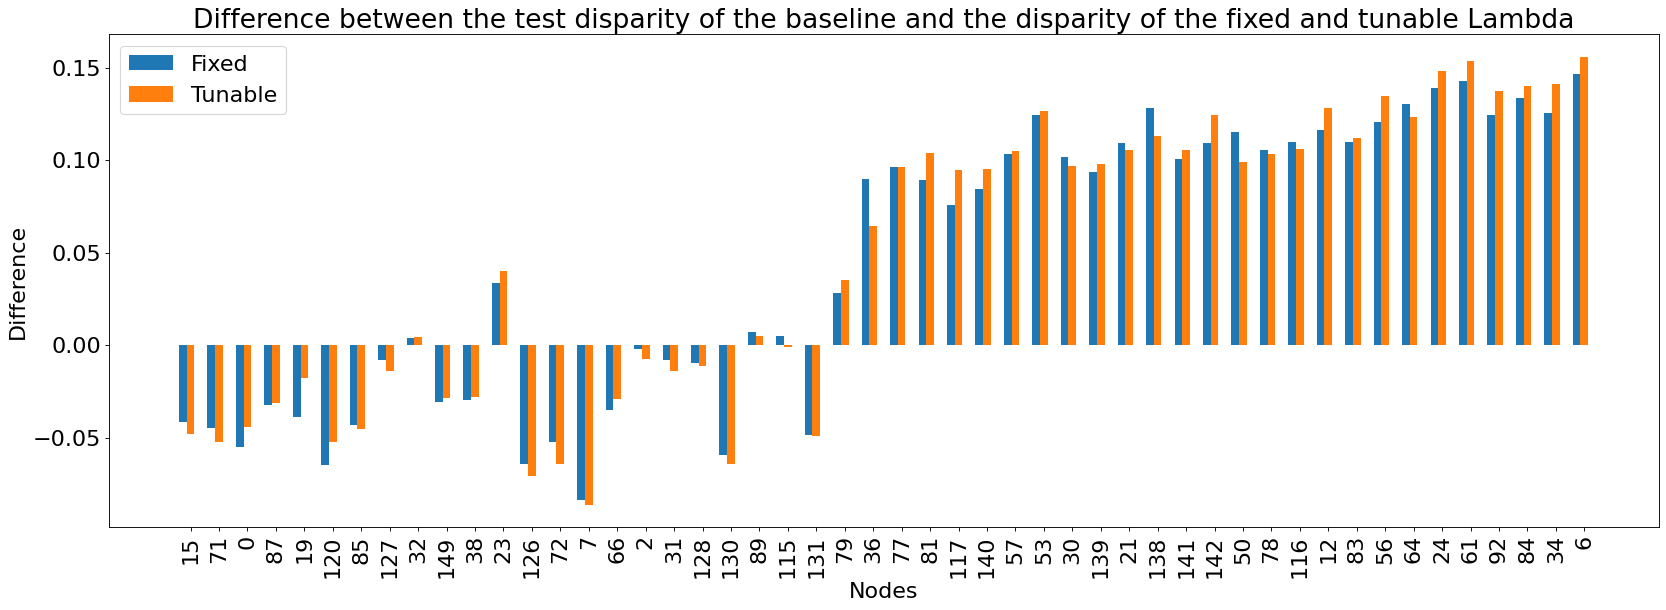

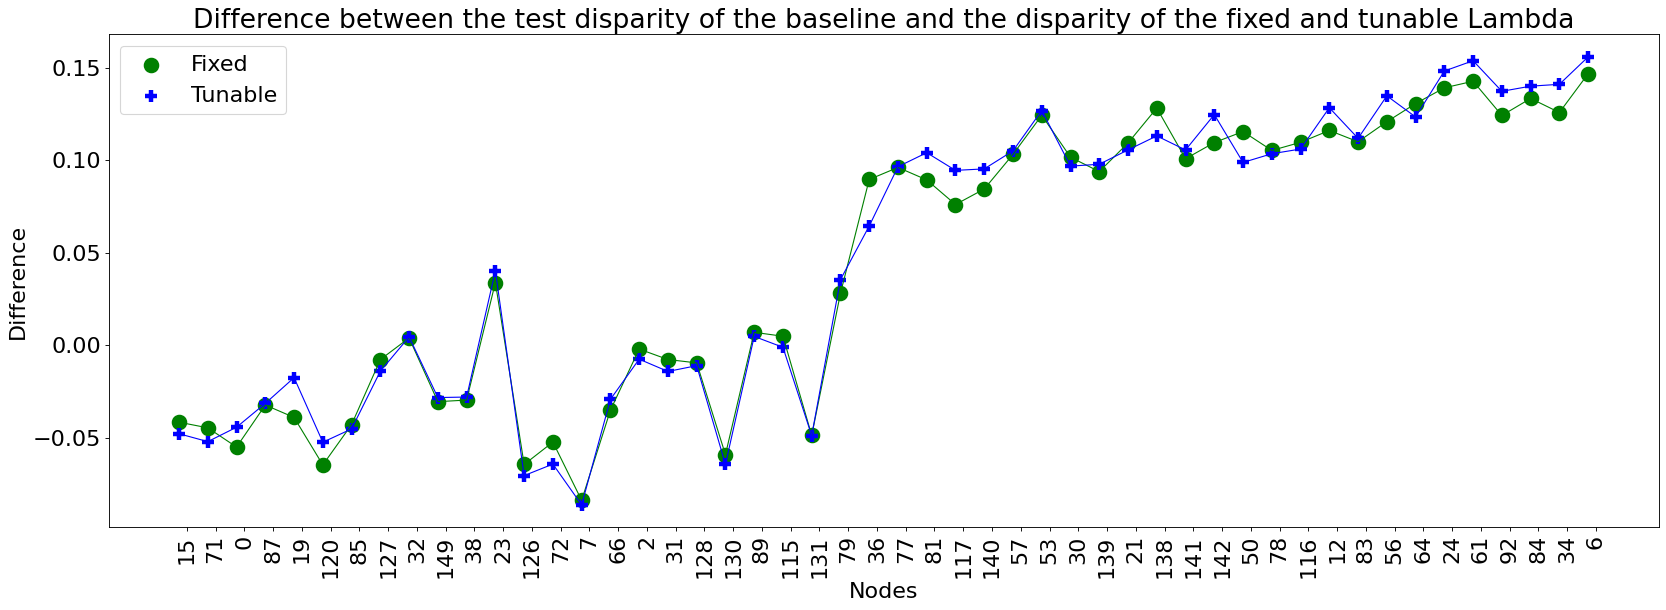

In [12]:
# 50 balanced 50 unbalanced
process_and_plot(baseline_link="/lucacorbucci/FL_fairness/runs/ydjnxo29", fixed_link="/lucacorbucci/FL_PUF_Sweep/runs/idnts6o5", tunable_link="/lucacorbucci/FL_fairness/runs/gprysgcv", experiment="50_50", target=0.05)

In [13]:
tunable_link = "/lucacorbucci/FL_fairness/runs/gprysgcv"
df_tunable = get_df(tunable_link)

In [14]:
lambda_columns = df_tunable[train_nodes_columns]
disparity_columns_before = df_tunable[train_nodes_columns_disparity_before]
disparity_columns_after = df_tunable[train_nodes_columns_disparity]

In [15]:
lambdas = {}
for column_name in lambda_columns.columns:
    node_name = str(column_name.split(" ")[2])
    lambdas[node_name] = list(lambda_columns[column_name].dropna())

disparities_before = {}
for column_name in disparity_columns_before.columns:
    node_name = str(column_name.split(" ")[2])
    disparities_before[node_name] = list(disparity_columns_before[column_name].dropna())

disparities_after = {}
for column_name in disparity_columns_after.columns:
    node_name = str(column_name.split(" ")[2])
    disparities_after[node_name] = list(disparity_columns_after[column_name].dropna())

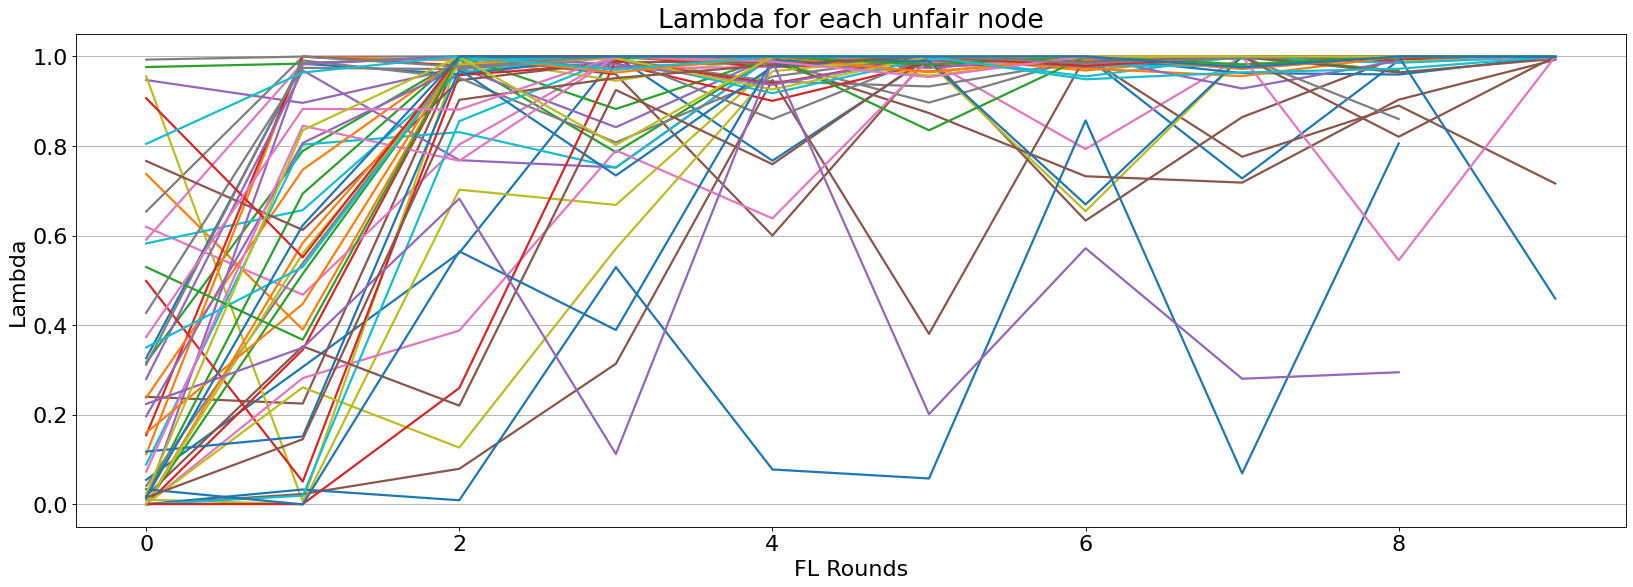

In [16]:
# plot the lambdas
figure(figsize=(25, 8), dpi=80)
ax = plt.axes()
ax.yaxis.grid()
for node_name, values in lambdas.items():
    if int(node_name) <= 75:
        plt.plot(values, linewidth=2, label=node_name)
plt.xlabel("FL Rounds")
plt.ylabel("Lambda")
plt.title(f"Lambda for each unfair node")
plt.savefig("Lambda_for_each_unfair_node.png")


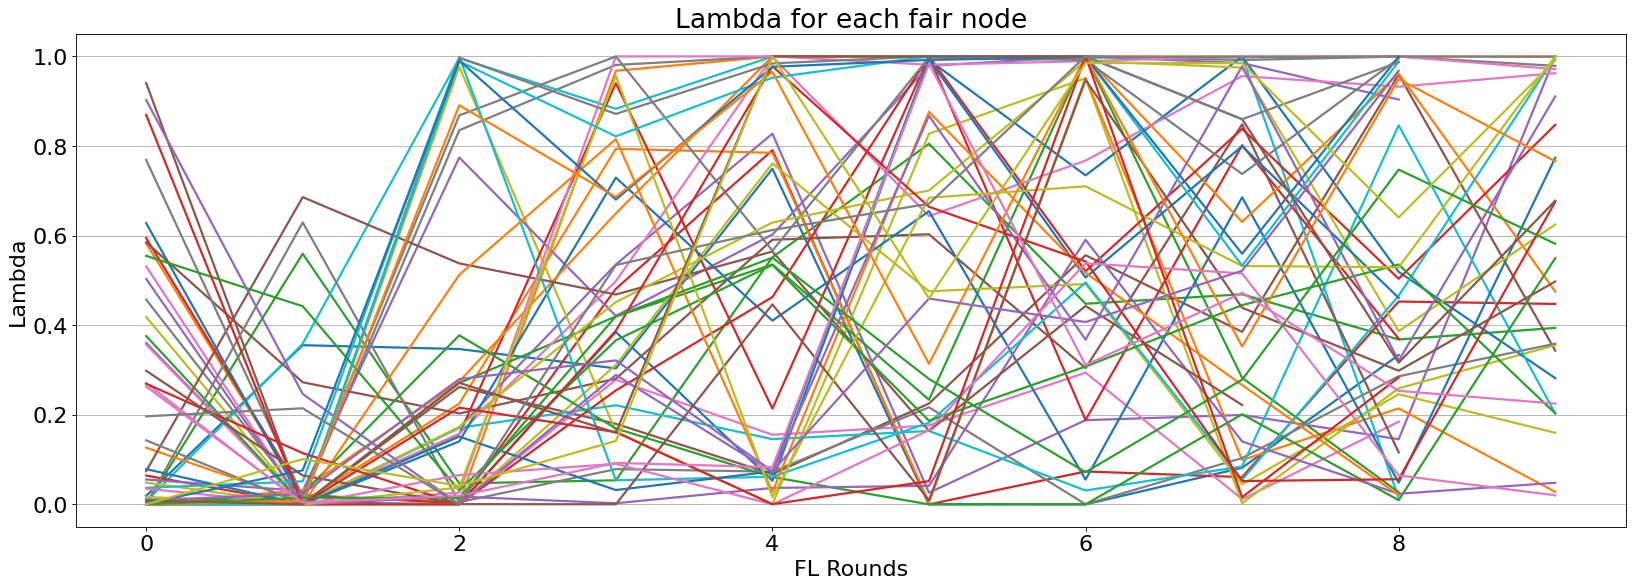

In [17]:
# plot the lambdas
figure(figsize=(25, 8), dpi=80)
ax = plt.axes()
ax.yaxis.grid()
for node_name, values in lambdas.items():
    if int(node_name) > 75:
        plt.plot(values, linewidth=2, label=node_name)
plt.xlabel("FL Rounds")
plt.ylabel("Lambda")
plt.title(f"Lambda for each fair node")
plt.savefig("Lambda_for_each_fair_node.png")


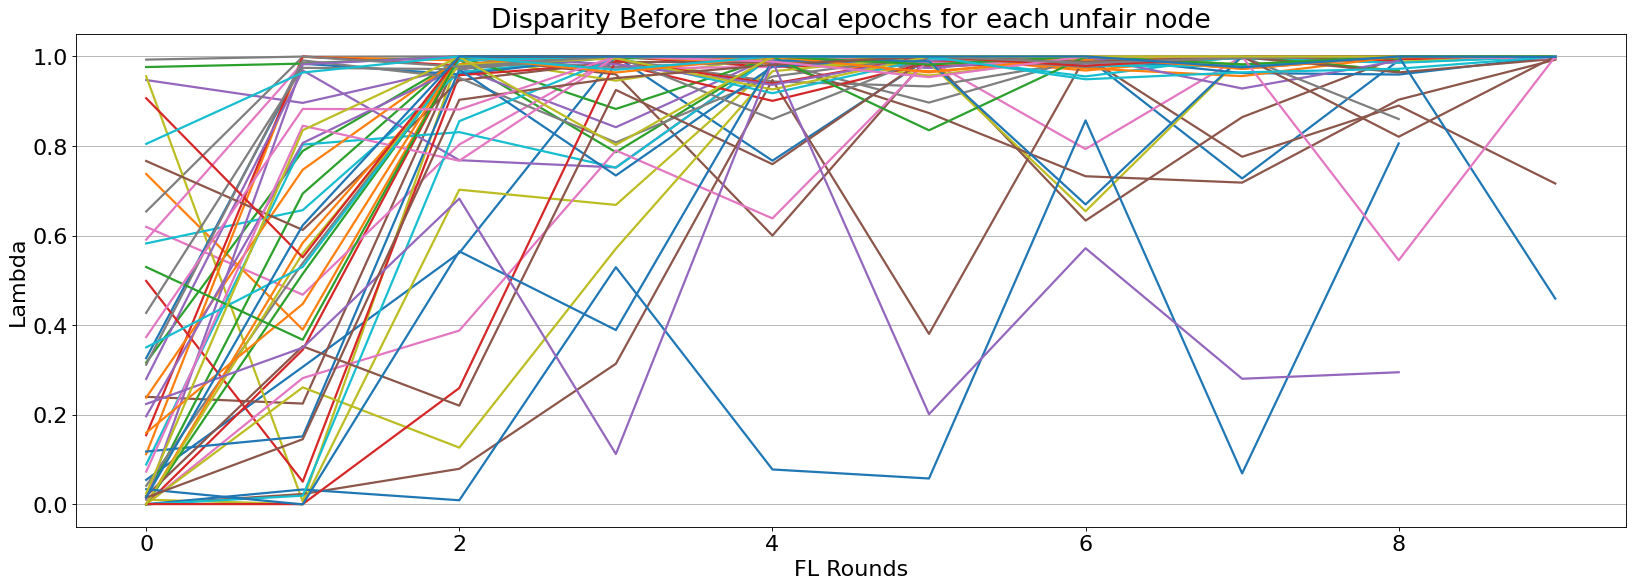

In [18]:
# plot the lambdas
figure(figsize=(25, 8), dpi=80)
ax = plt.axes()
ax.yaxis.grid()
for node_name, values in lambdas.items():
    if int(node_name) <= 75:
        plt.plot(values, linewidth=2, label=node_name)
plt.xlabel("FL Rounds")
plt.ylabel("Lambda")
plt.title(f"Disparity Before the local epochs for each unfair node")
plt.savefig("disparity_before_for_each_unfair_node.png")


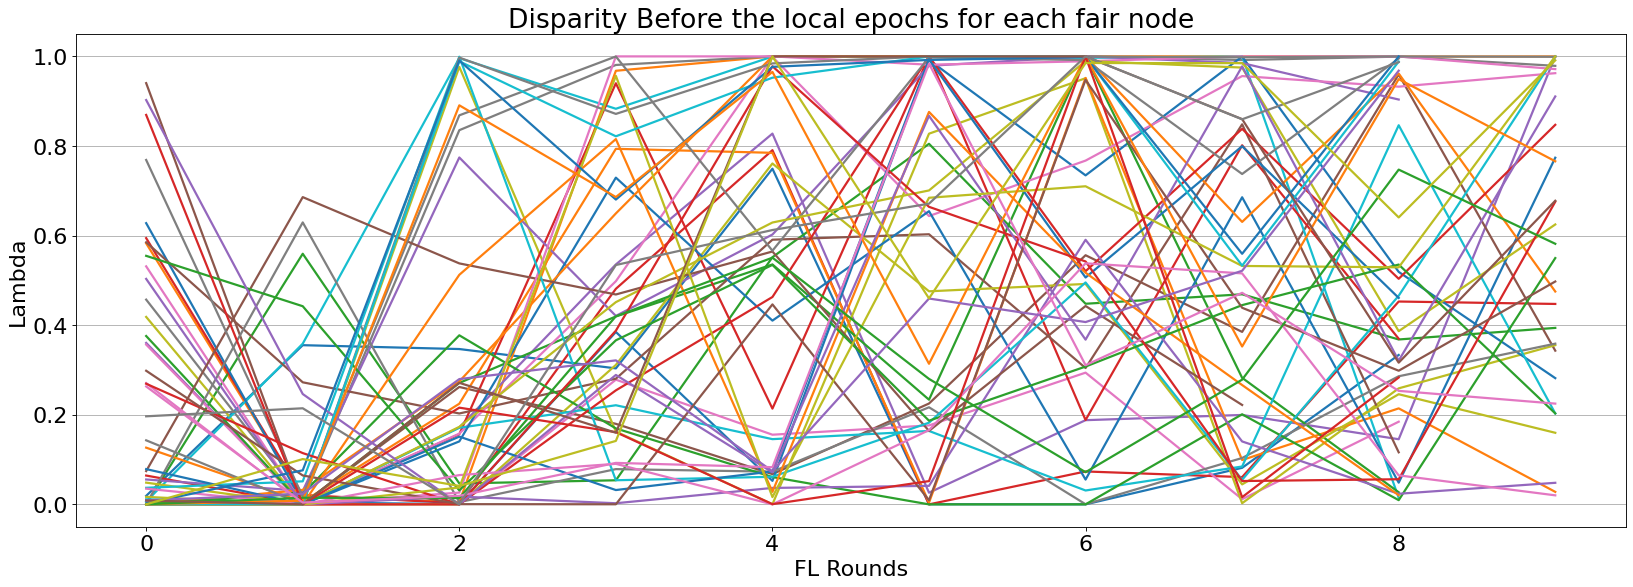

In [19]:
# plot the lambdas
figure(figsize=(25, 8), dpi=80)
ax = plt.axes()
ax.yaxis.grid()
for node_name, values in lambdas.items():
    if int(node_name) > 75:
        plt.plot(values, linewidth=2, label=node_name)
plt.xlabel("FL Rounds")
plt.ylabel("Lambda")
plt.title(f"Disparity Before the local epochs for each fair node")
plt.savefig("disparity_before_for_each_fair_node.png")



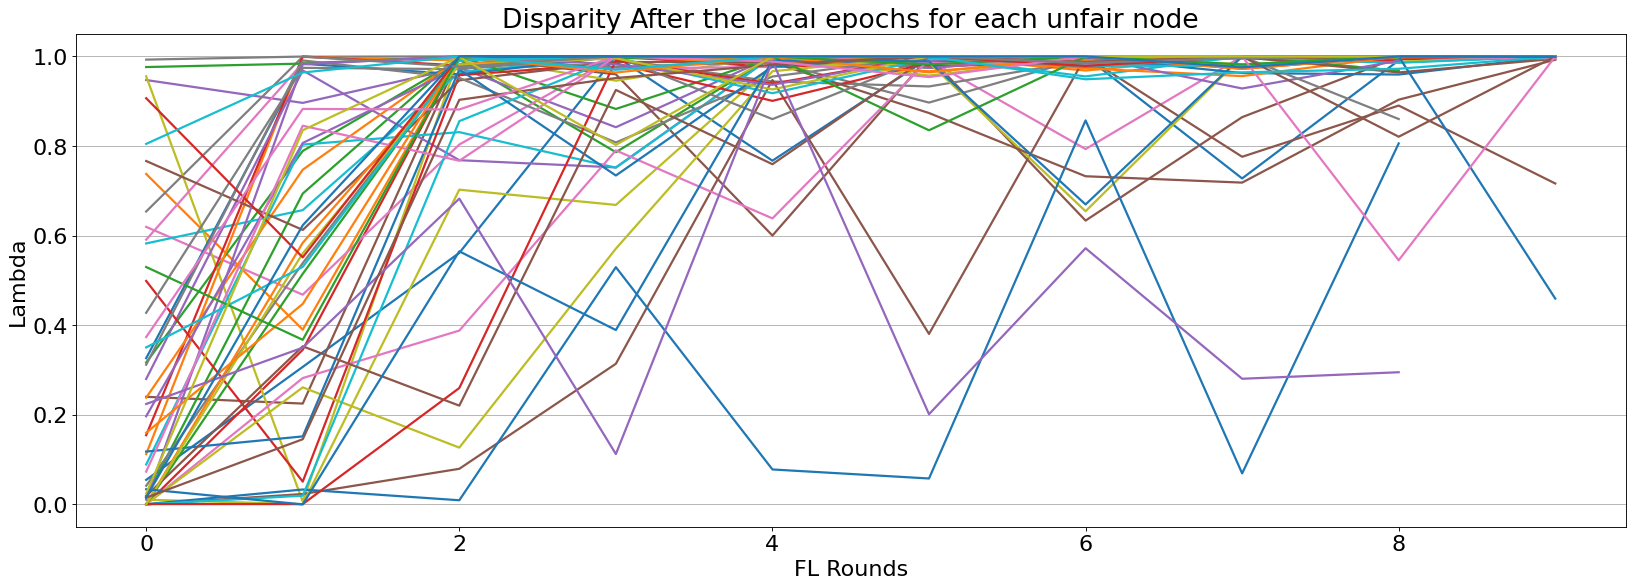

In [20]:
# plot the lambdas
figure(figsize=(25, 8), dpi=80)
ax = plt.axes()
ax.yaxis.grid()
for node_name, values in lambdas.items():
    if int(node_name) <= 75:
        plt.plot(values, linewidth=2, label=node_name)
plt.xlabel("FL Rounds")
plt.ylabel("Lambda")
plt.title(f"Disparity After the local epochs for each unfair node")
plt.savefig("disparity_after_for_each_unfair_node.png")


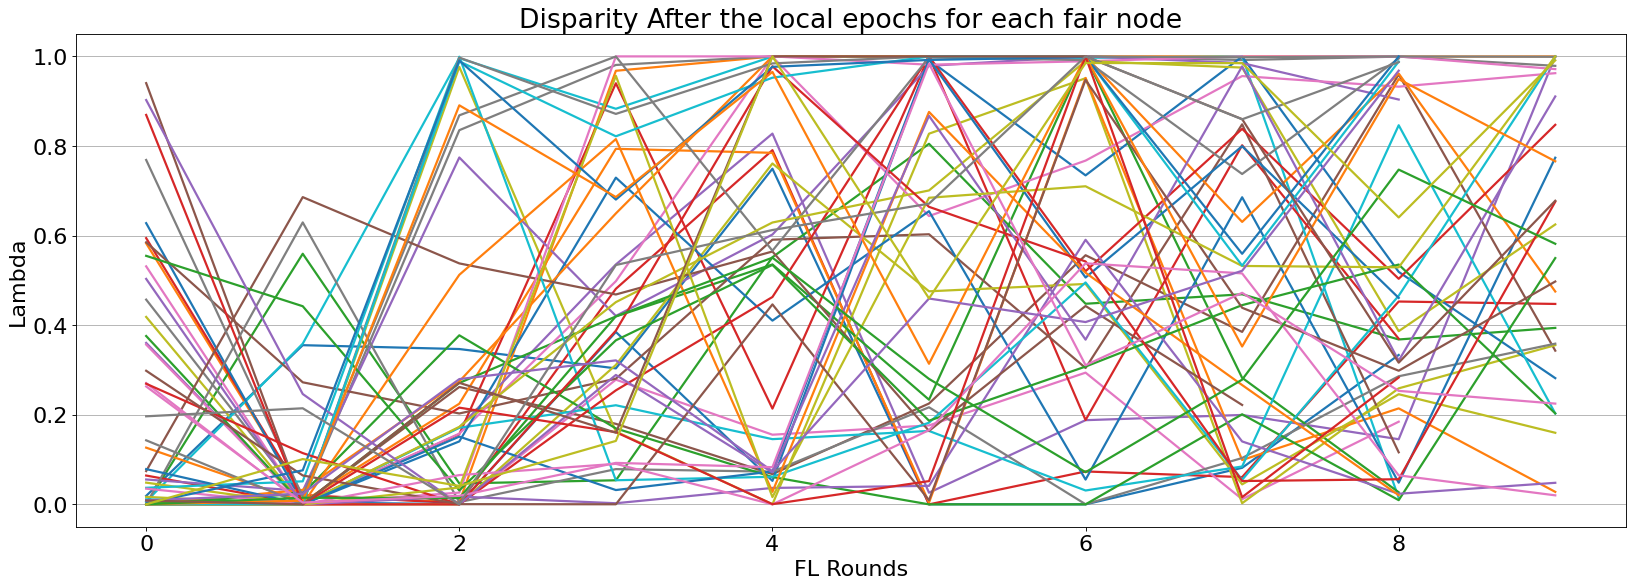

In [21]:
# plot the lambdas
figure(figsize=(25, 8), dpi=80)
ax = plt.axes()
ax.yaxis.grid()
for node_name, values in lambdas.items():
    if int(node_name) > 75:
        plt.plot(values, linewidth=2, label=node_name)
plt.xlabel("FL Rounds")
plt.ylabel("Lambda")
plt.title(f"Disparity After the local epochs for each fair node")
plt.savefig("disparity_after_for_each_fair_node.png")


# Non IID

['Test Node 15 - Disp. Dataset', 'Test Node 71 - Disp. Dataset', 'Test Node 0 - Disp. Dataset', 'Test Node 87 - Disp. Dataset', 'Test Node 19 - Disp. Dataset', 'Test Node 120 - Disp. Dataset', 'Test Node 85 - Disp. Dataset', 'Test Node 127 - Disp. Dataset', 'Test Node 32 - Disp. Dataset', 'Test Node 149 - Disp. Dataset', 'Test Node 38 - Disp. Dataset', 'Test Node 23 - Disp. Dataset', 'Test Node 126 - Disp. Dataset', 'Test Node 72 - Disp. Dataset', 'Test Node 7 - Disp. Dataset', 'Test Node 66 - Disp. Dataset', 'Test Node 2 - Disp. Dataset', 'Test Node 31 - Disp. Dataset', 'Test Node 128 - Disp. Dataset', 'Test Node 130 - Disp. Dataset', 'Test Node 89 - Disp. Dataset', 'Test Node 115 - Disp. Dataset', 'Test Node 131 - Disp. Dataset', 'Test Node 79 - Disp. Dataset', 'Test Node 36 - Disp. Dataset', 'Test Node 77 - Disp. Dataset', 'Test Node 81 - Disp. Dataset', 'Test Node 117 - Disp. Dataset', 'Test Node 140 - Disp. Dataset', 'Test Node 57 - Disp. Dataset', 'Test Node 53 - Disp. Dataset', 

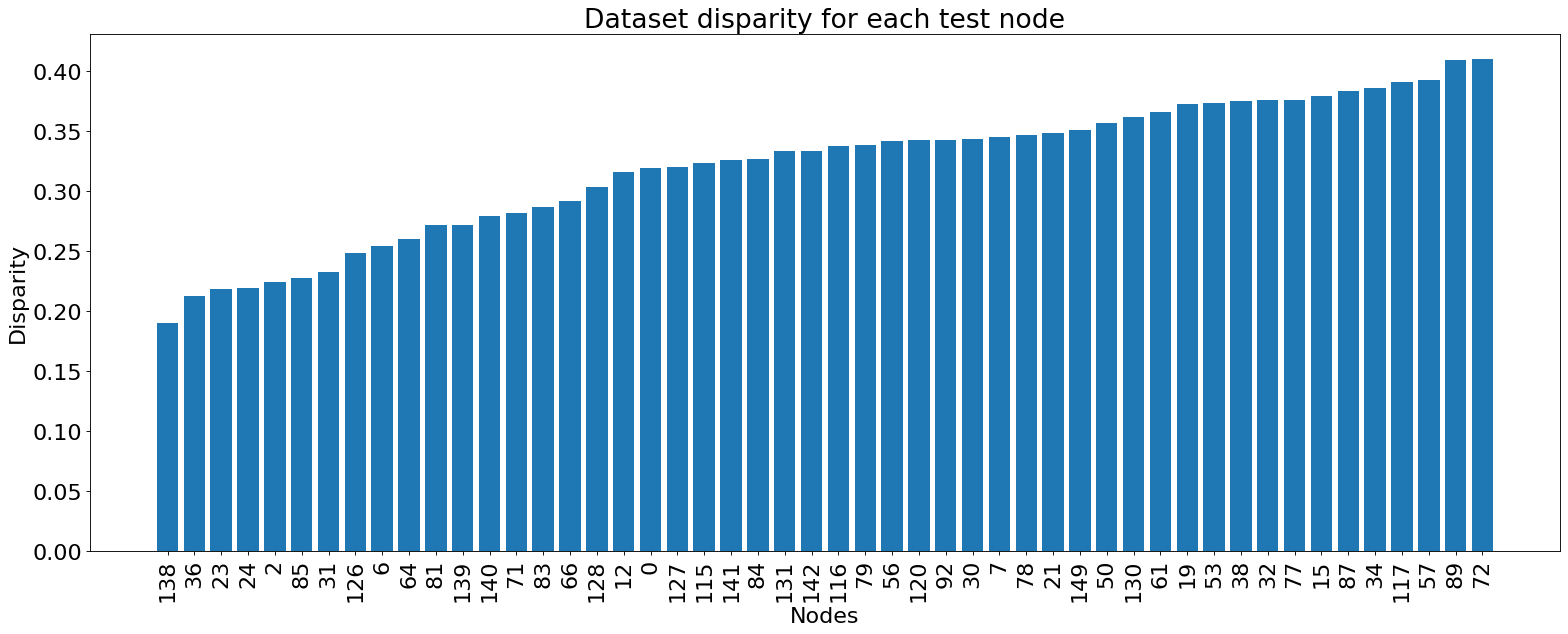

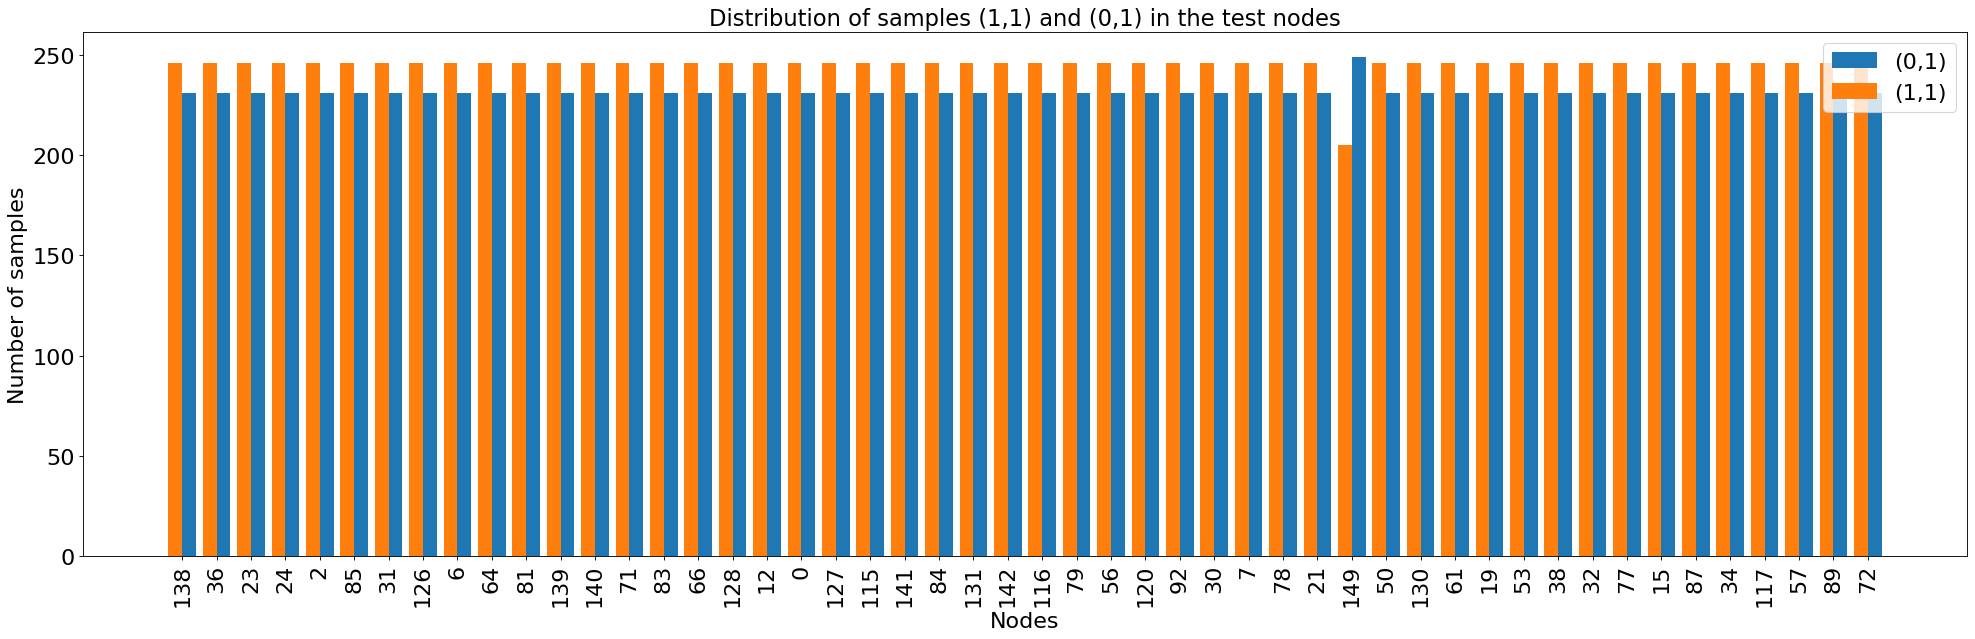

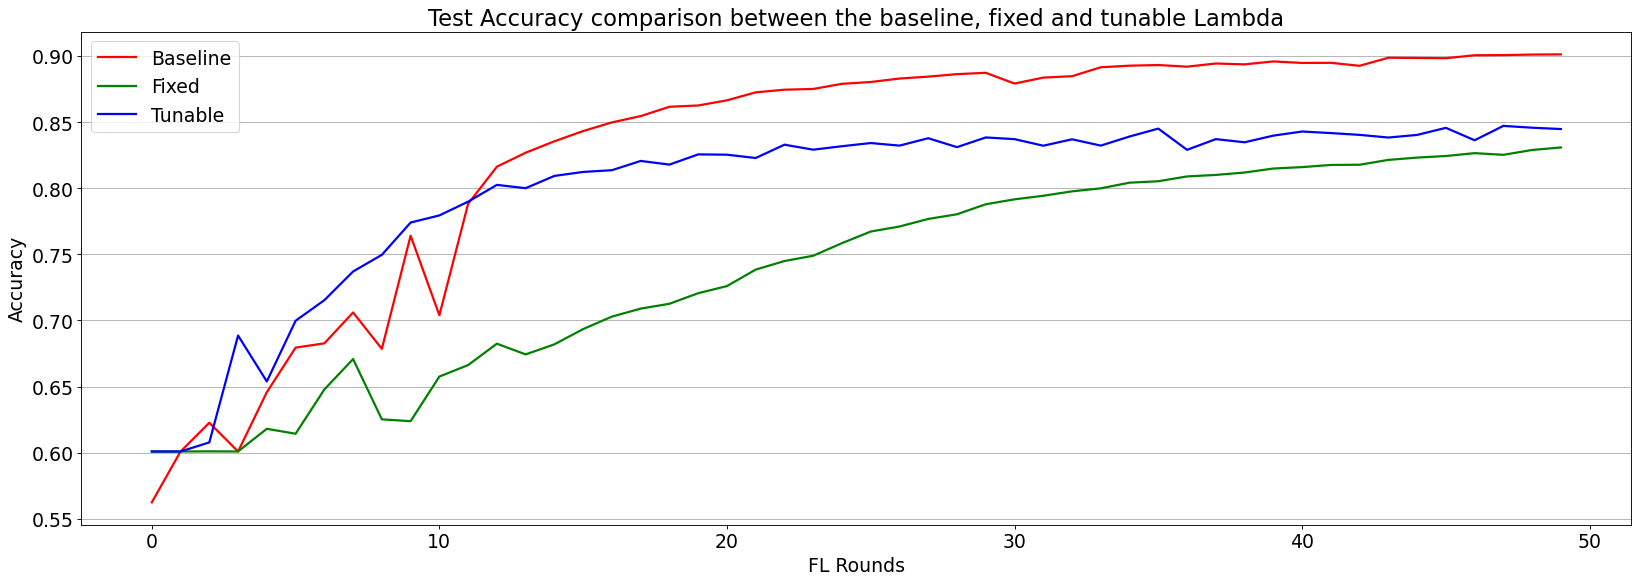

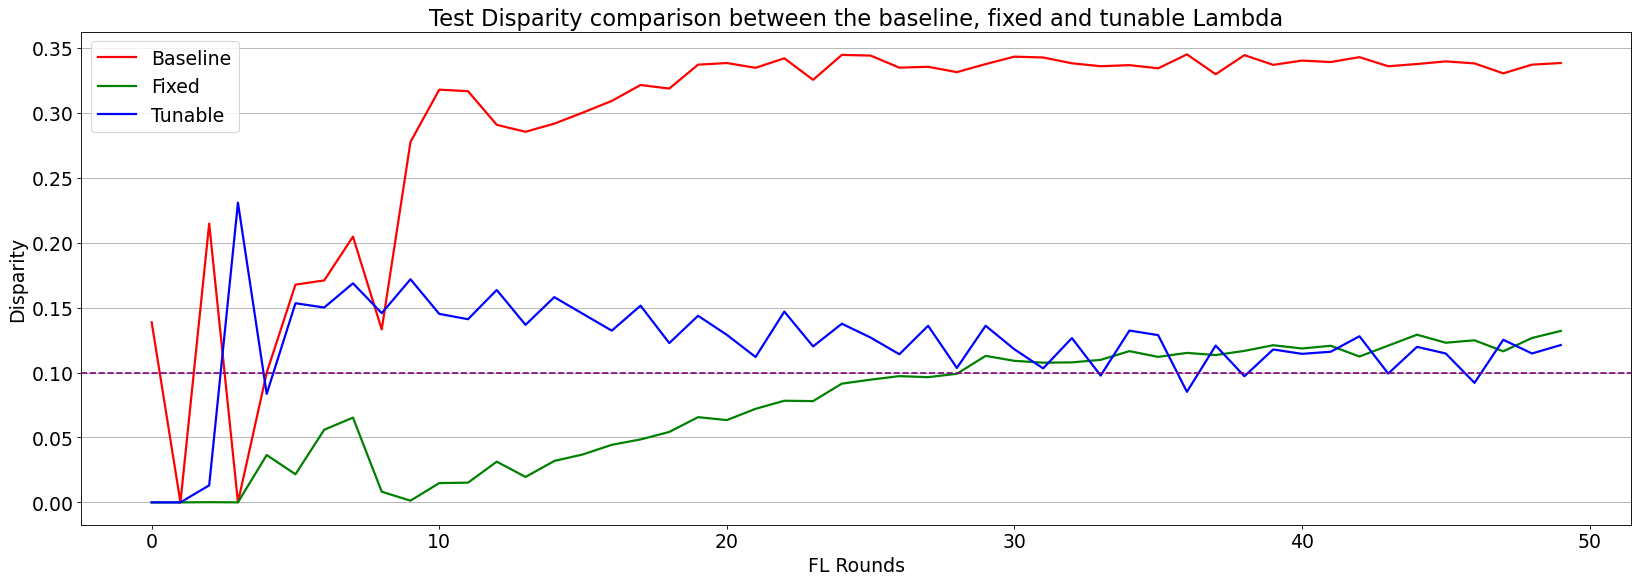

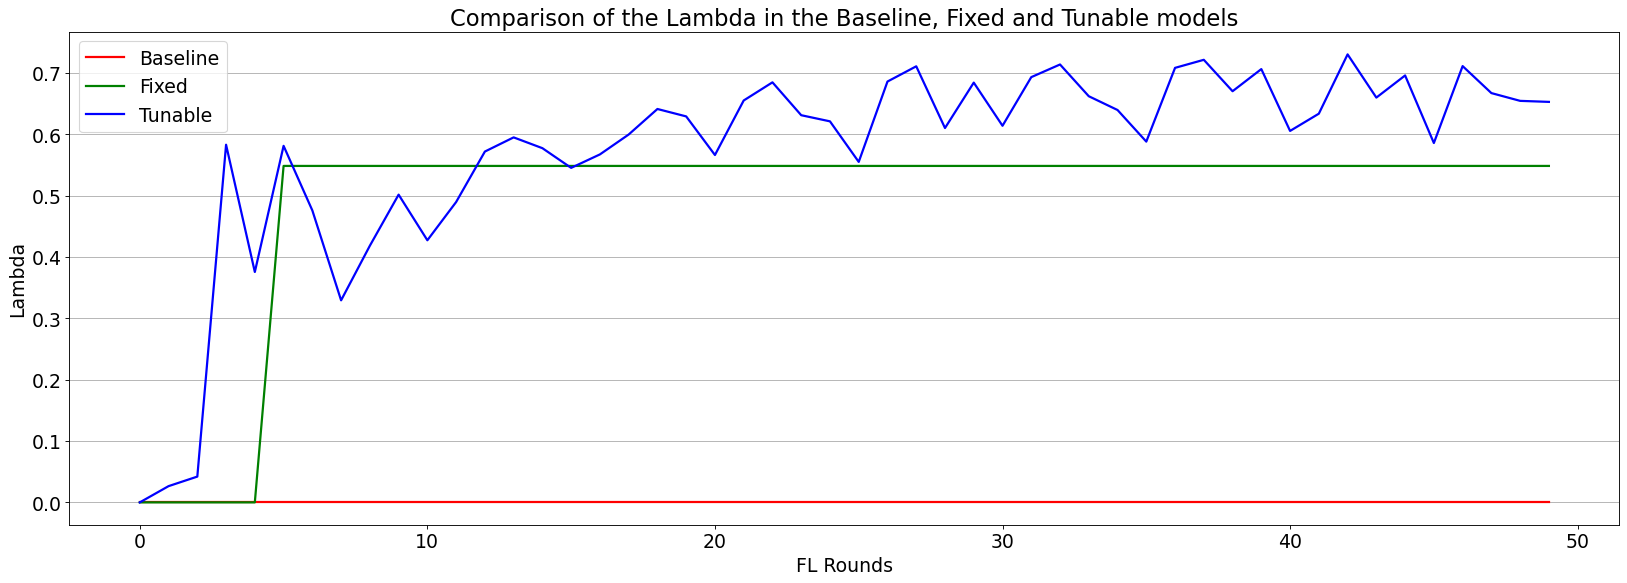

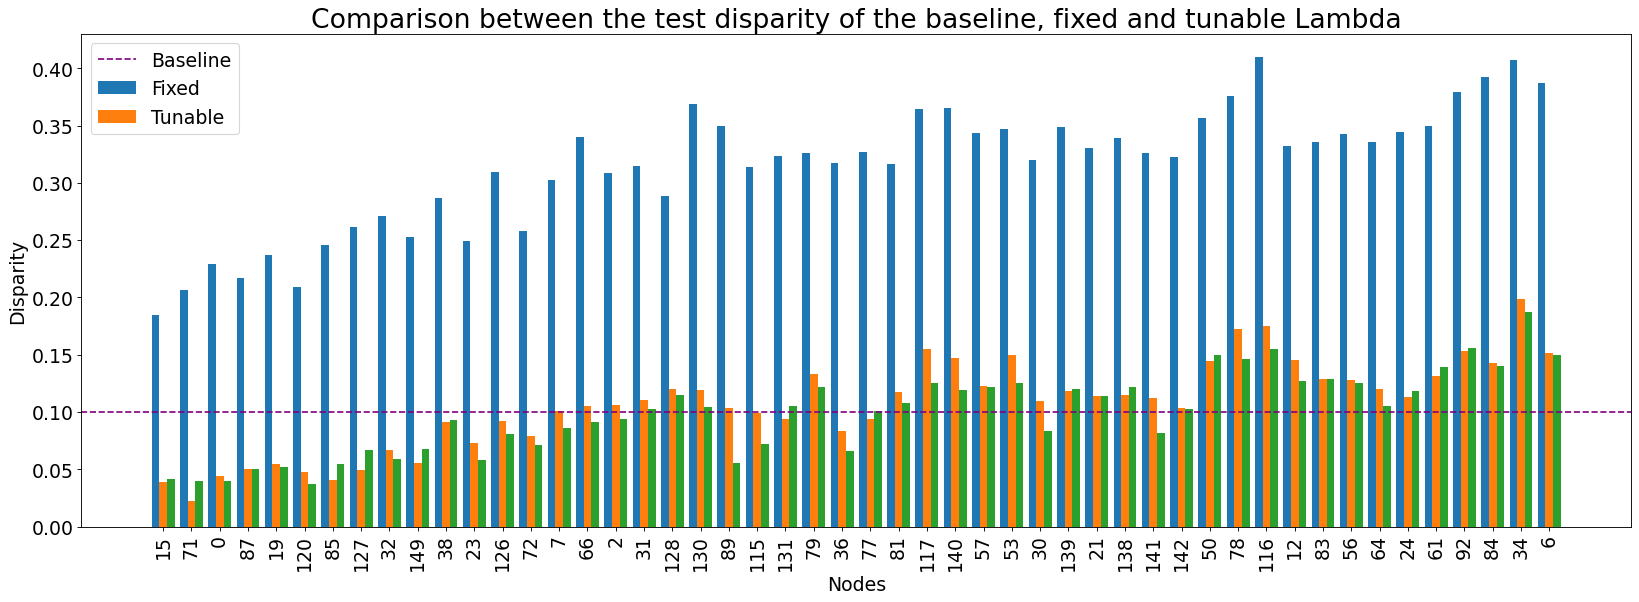

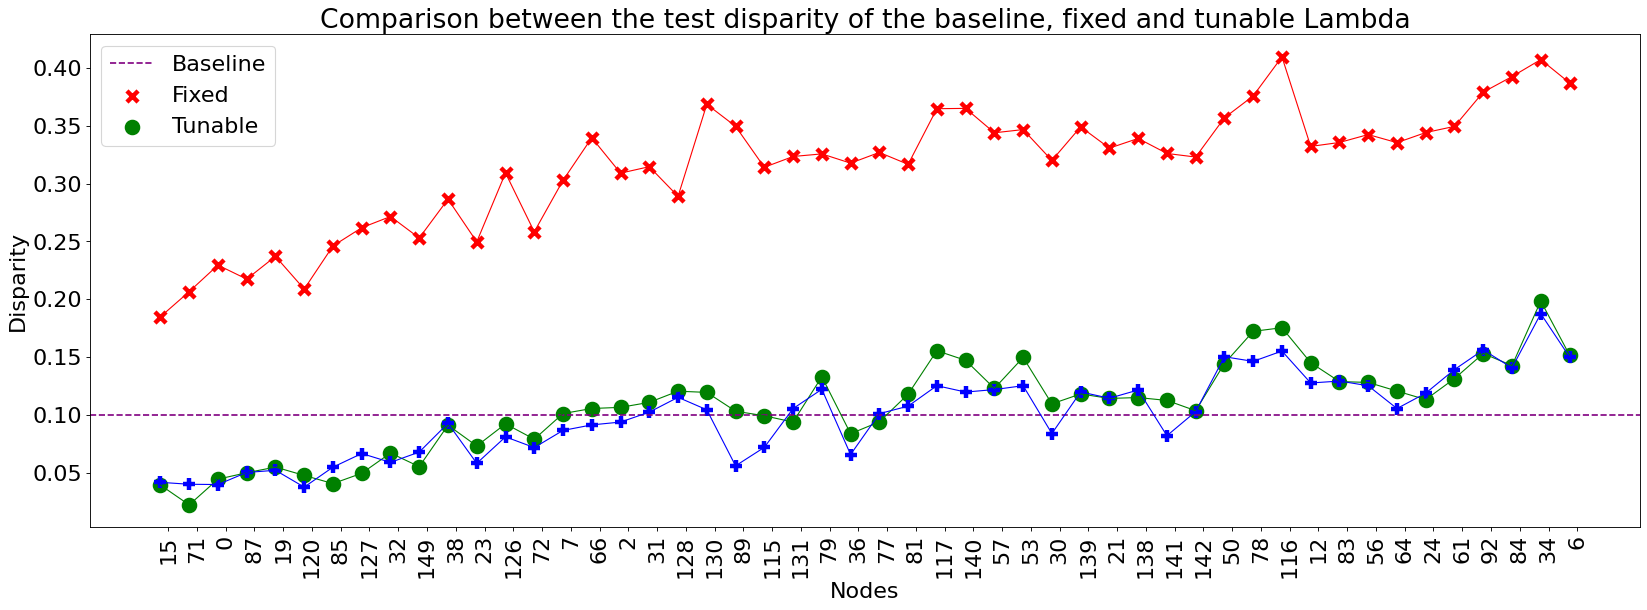

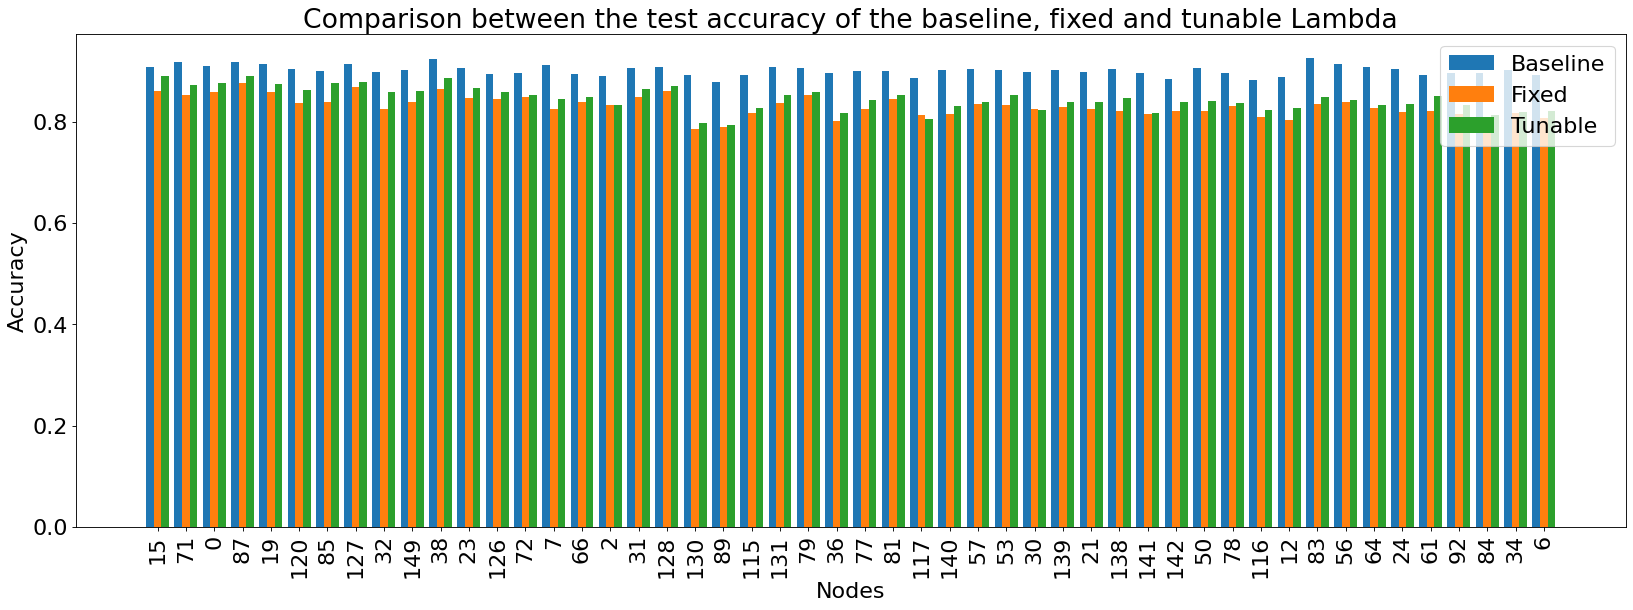

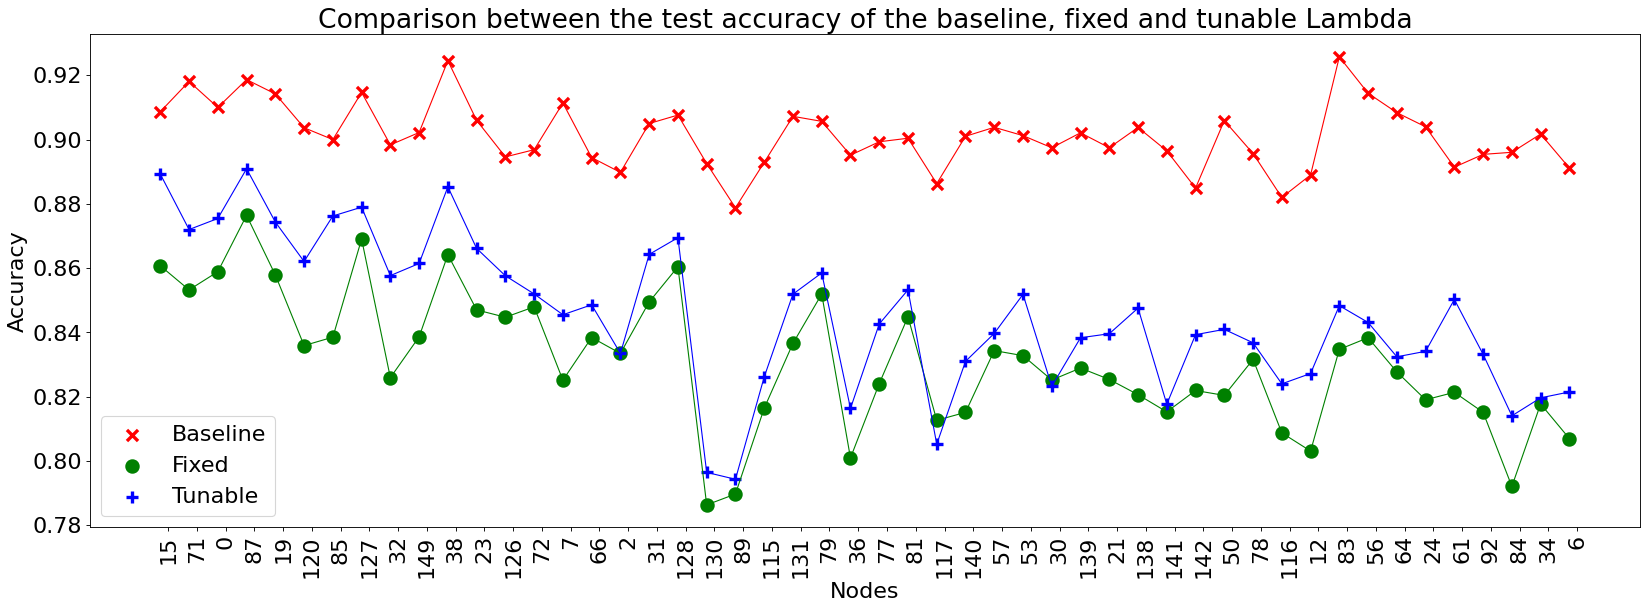

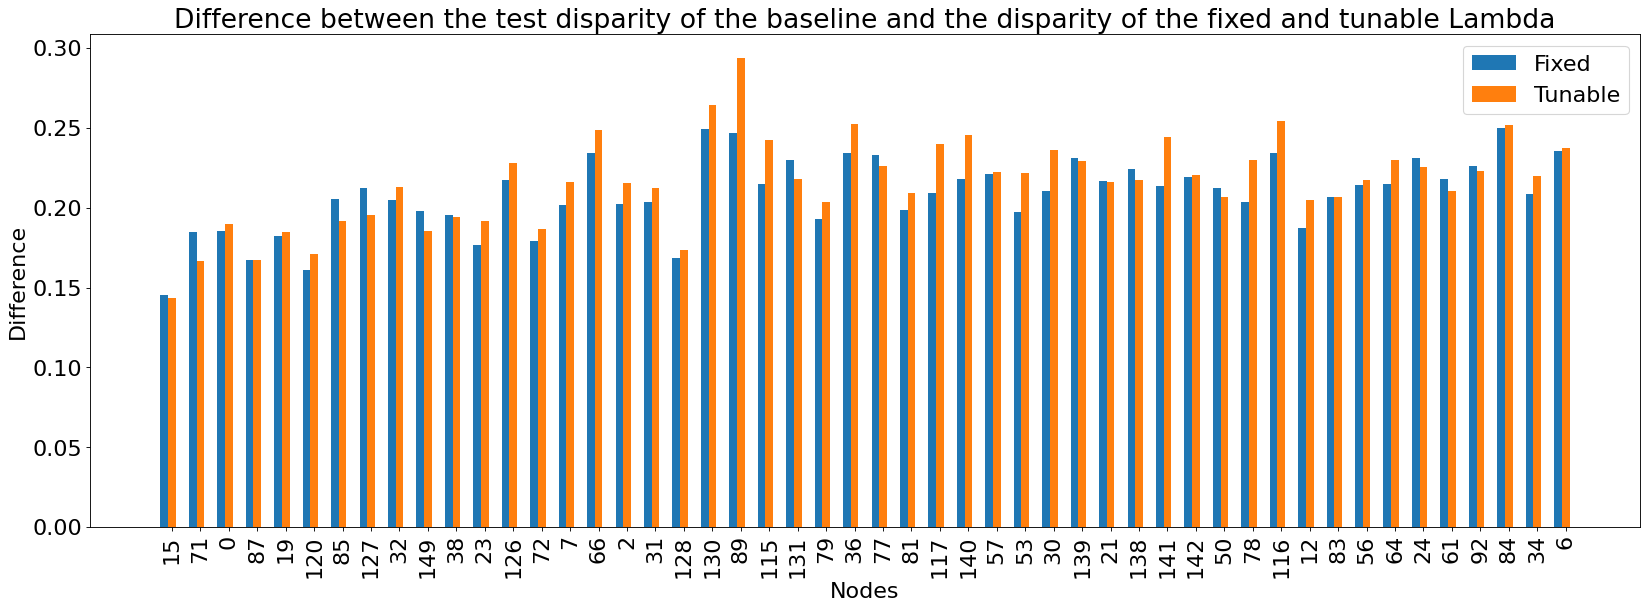

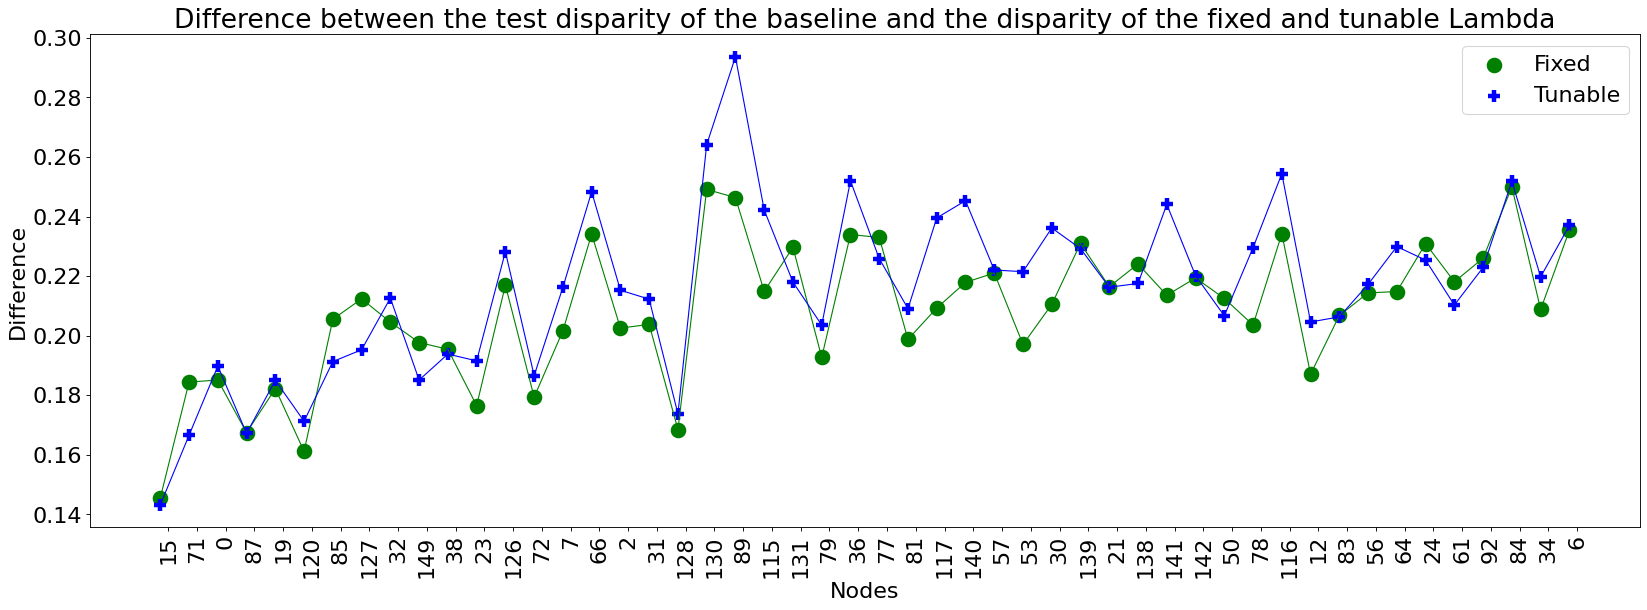

In [22]:
# Non IID
process_and_plot(baseline_link="/lucacorbucci/FL_fairness/runs/ng91bamk", fixed_link="/lucacorbucci/FL_fairness/runs/2jjx2hjh", tunable_link="/lucacorbucci/FL_fairness/runs/xunyy81c", experiment="non_iid", target=0.1)